In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
#!unzip /content/drive/MyDrive/eFlowData/tfrecord/room3_40/room3_40.zip

#!unzip /content/drive/MyDrive/eFlowData/tfrecord/room3_64/room3_64.zip

#unzip /content/drive/MyDrive/eFlowData/tfrecord/room3_128/room3_128.zip

!unzip /content/drive/MyDrive/ColabNotebooks/data_256.zip



Archive:  /content/drive/MyDrive/ColabNotebooks/data_256.zip
mapname:  conversion of  failed
replace train/pFlow-00014-of-00039.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: train/pFlow-00014-of-00039.zip  
 extracting: train/pFlow-00013-of-00039.zip  
 extracting: train/pFlow-00017-of-00039.zip  
 extracting: train/pFlow-00016-of-00039.zip  
 extracting: train/pFlow-00015-of-00039.zip  
 extracting: train/pFlow-00018-of-00039.zip  
 extracting: validation/pFlow-00001-of-00039.zip  
 extracting: validation/pFlow-00000-of-00039.zip  


In [ ]:
#!cp -r /content/drive/MyDrive/pFlow-00039-of-00039.tfrecord /content/

In [22]:
#
import os
import datetime
import ast
import string
import random
from ast import literal_eval
from abc import ABC, abstractmethod
from timeit import default_timer as timer
import json
import csv
import pprint


import numpy as np

import tensorflow as tf


from tensorflow import keras
from keras import Model, layers, Sequential
from keras.utils import plot_model
from keras.layers import (Input, Conv2D, Conv3D, ReLU, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Concatenate, ConvLSTM2D, ConvLSTM1D, Conv2DTranspose, Conv3DTranspose, Flatten, LSTM,
                          Dense, Reshape, RepeatVector, ZeroPadding2D, Dropout, BatchNormalization, TimeDistributed, ConvLSTM3D, concatenate)
from keras.regularizers import l2

import matplotlib.pyplot as plt
from matplotlib import colors, cm


print("Tensorflow version " + tf.__version__)

tpu = False
if tpu:
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    print("All devices: ", tf.config.list_logical_devices('TPU'))


    tpu_strategy = tf.distribute.TPUStrategy(tpu)
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

Tensorflow version 2.17.1


In [23]:
device_name = tf.test.gpu_device_name()
with tf.device('/device:GPU:0'):
  random_image_gpu = tf.random.normal((100, 100, 100, 3))
  net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
  tf.math.reduce_sum(net_gpu)
  print(device_name)

/device:GPU:0


In [24]:
time_stride = 1
time_stride_random = False
feature_time_steps=time_stride*50
label_time_steps=time_stride*50
pred_steps=50
initial_step_pred=5
if tpu:
  batch_size= 2 * tpu_strategy.num_replicas_in_sync
  print(tpu_strategy.num_replicas_in_sync)
else:
  batch_size= 6
epoch=32

path = '/content'
print(batch_size)


6



# Analyse Klasse


In [25]:
class Analyse():
    def __init__(self, files=None, size_geometry=(40, 40), files_num=0,
                 dataset_rho_v_phi=None, dataset_rho_v=None, dataset_rho_phi=None, dataset_rho=None,
                 dataset_rho_vx_vy_phi=None, dataset_rho_vx_vy=None,
                 x=None, y_rho=None, y_v=None, y_phi=None, analyse_params=None,  time_stride=1, time_stride_random=False):
        self.files = files
        self.files_num = files_num
        self.size_geometry = size_geometry
        self.data = []
        self.dataset_rho_v_phi = dataset_rho_v_phi
        self.dataset_rho_v = dataset_rho_v
        self.dataset_rho_phi = dataset_rho_phi
        self.dataset_rho = dataset_rho
        self.dataset_rho_vx_vy_phi = dataset_rho_vx_vy_phi
        self.dataset_rho_vx_vy = dataset_rho_vx_vy
        self.x = x
        self.y_rho = y_rho
        self.y_v = y_v
        self.y_phi = y_phi
        self.rho_min_max = [[None], [None]]
        self.v_min_max = [[None], [None]]
        self.phi_min_max = [[None], [None]]
        self.analyse_param = analyse_params
        self.time_steps = 500
        self.time_stride = time_stride
        self.time_stride_random = time_stride_random
        self.size_data = 0

        self.room_width_to_door_width_ration = [0]*10
        self.door_orientation = [0]*2
        self.room_shape = [0]*10
        self.door_position = [0]*10
        self.corridor_length_to_width_ratio = [0]*2
        self.building_area_to_room_area_ratio = [0]*10
        self.room_area_to_obstacle_area_ratio = [0]*10
        self.exit_to_room_ratio = [0]*10
        self.room_area = []
        self.hallway_area = []
        self.building_area = []
        self.obstacle_area = []
        self.room_area_mean = []
        self.hallway_area_mean = []
        self.building_area_mean = []
        self.obstacle_area_mean = []
        self.num_rooms = [0]*10
        self.num_exits = [0]*10
        self.num_entrance = [0]*10
        self.inner_walls = [0]*10
        self.min_room_size = []
        self.size_walls = []
        self.door_width = []
        self.calculation_time_eFlow = []
        self.json = None
        # Todo: varianz median ect auf function hier noch mit rein. sowie möglichkeit für Print von Bildern

    def run(self):
        if self.dataset_rho_v_phi is None:
            self.load_data()
        self.decode_dict()
        self.analyse()
        self.print_analyse()
        self.json_()

    def load_data(self):
        (self.dataset_rho_v_phi, self.dataset_rho, self.dataset_rho_v, self.dataset_rho_phi,
         self.dataset_rho_vx_vy_phi, self.dataset_rho_vx_vy, self.x, self.y_rho,
         self.y_v, self.y_phi, self.analyse_param) = (read_tfrecord(take_exp=0, batch_size=1, shuffle=True,
                                                                    files=self.files[self.files_num],
                                                                    feature_time_steps=self.time_steps,
                                                                    label_time_steps=self.time_steps,
                                                                    size_geometry=self.size_geometry,
                                                                    time_stride_random=self.time_stride_random))

    def decode_dict(self):
        for data in self.analyse_param:
            s = data.numpy()[0]
            self.data.append(literal_eval(s.decode('utf-8'))[0])
        self.size_data = len(self.data)

        self.min_max(self.y_rho, self.rho_min_max)
        self.min_max(self.y_v, self.v_min_max)
        self.min_max(self.y_phi, self.phi_min_max)

    def min_max(self, dataset, min_max):
        for data in dataset:
            data = data.numpy()
            min = np.min(data)
            max = np.max(data)

            if min_max[0] == [None]:
                min_max[0] = min
                min_max[1] = max

            if min < min_max[0]:
                min_max[0] = min
            if max > min_max[1]:
                min_max[1] = max

    def analyse(self):
        for data in self.data:
            self.room_width_to_door_width_ration_(data['room_width_to_door_width_ration'])
            self.door_orientation_(data['door_orientation'])
            self.room_shape_(data['room_shape'])
            self.door_position_(data['door_position'])
            self.corridor_length_to_width_ratio_(data['corridor_length_to_width_ratio'])
            self.building_area_to_room_area_ratio_(data['building_area_to_room_area_ratio'])
            self.room_area_to_obstacle_area_ratio_(data['room_area_to_obstacle_area_ratio'])
            self.exit_to_room_ratio_(data['exit_to_room_ratio'])
            self.room_area_(data['room_area'])
            self.hallway_area_(data['hallway_area'])
            self.building_area_(data['building_area'])
            self.obstacle_area_(data['obstacle_area'])
            self.num_rooms_(data['num_rooms'])
            self.num_exits_(data['num_exits'])
            self.num_entrance_(data['num_entrance'])
            self.inner_walls_(data['inner_walls'])
            self.min_room_size_(data['min_room_size'])
            self.size_walls_(data['size_walls'])
            self.door_width_(data['door_width'])
            self.calculation_time_eFlow_(data['calculation_time_eFlow'])

    def room_width_to_door_width_ration_(self, data):
        # Türbreite/Raumbreite
        for d in data:
            self.room_width_to_door_width_ration[int(d * 10)] += 1

    def door_orientation_(self, data):
        for d in data:
            if d < 1:
                # Türe befindet sich an kurzer Seite des Raumes
                self.door_orientation[0] += 1
            else:
                # Türe befindet sich an breiter Seite des Raumes
                self.door_orientation[1] += 1

    def room_shape_(self, data):
        # 1 Rechteck, gegen 0 Schmaller und länglicher
        for d in data:
            if d < 1:
                self.room_shape[int(d * 10)] += 1
            else:
                self.room_shape[9] += 1

    def door_position_(self, data):
        # 1 = mittig, gegen 0: weiter richtung Ecke / Wand
        try:
            for d in data:
                self.door_position[int(d * 10)] += 1
        except IndexError:
            self.door_position[9] += 1

    def corridor_length_to_width_ratio_(self, data):
        # 1 = Quatratisch, <1: Länge>Breite, >1: Breite>Länge
        for d in data:
            if d < 1:
                # Länge > Breite
                self.corridor_length_to_width_ratio[0] += 1
            else:
                # Länge < Breite
                self.corridor_length_to_width_ratio[1] += 1

    def building_area_to_room_area_ratio_(self, data):
        if data < 1:
            self.building_area_to_room_area_ratio[int(data * 10)] += 1
        else:
            self.building_area_to_room_area_ratio[9] += 1

    def room_area_to_obstacle_area_ratio_(self, data):
        self.room_area_to_obstacle_area_ratio[int(data * 10)] += 1

    def exit_to_room_ratio_(self, data):
        for d in data:
            self.exit_to_room_ratio[int(d * 10)] += 1

    def room_area_(self, data):
        for d in data:
            self.room_area.append(d)

    def hallway_area_(self, data):
        for d in data:
            self.hallway_area.append(d)

    def building_area_(self, data):
        self.building_area.append(data)

    def obstacle_area_(self, data):
        for d in data:
            self.obstacle_area.append(d)

    def num_rooms_(self, data):
        self.num_rooms[int(data)] += 1

    def num_exits_(self, data):
        self.num_exits[int(data)] += 1

    def num_entrance_(self, data):
        self.num_entrance[int(data)] += 1

    def inner_walls_(self, data):
        self.inner_walls[int(data)] += 1

    def min_room_size_(self, data):
        self.min_room_size.append(data)

    def size_walls_(self, data):
        if len(self.size_walls) == 0:
            self.size_walls.append(data)
        for n in self.size_walls:
            if n != data:
                self.size_walls.append(data)

    def door_width_(self, data):
        if len(self.door_width) == 0:
            self.door_width.append(data)
        for n in self.door_width:
            if n != data:
                self.door_width.append(data)

    def calculation_time_eFlow_(self, data):
        self.calculation_time_eFlow.append(data)

    def print_analyse(self, print_output=False):

        self.room_area_mean = int(np.mean(self.room_area))
        self.room_area = [min(self.room_area), max(self.room_area)]

        if len(self.hallway_area) > 0:
            self.hallway_area_mean = int(np.mean(self.hallway_area))
            self.hallway_area = [min(self.hallway_area), max(self.hallway_area)]

        self.building_area_mean = int(np.mean(self.building_area))
        self.building_area = [min(self.building_area), max(self.building_area)]

        self.obstacle_area_mean = int(np.mean(self.obstacle_area))
        self.obstacle_area = [min(self.obstacle_area), max(self.obstacle_area)]

        try:
            self.num_rooms = self.num_rooms.index(self.size_data)
        except ValueError:
            pass

        try:
            self.num_exits = self.num_exits.index(self.size_data)
        except ValueError:
            pass

        try:
            self.num_entrance = self.num_entrance.index(self.size_data)
        except ValueError:
            pass

        try:
            self.inner_walls = self.inner_walls.index(self.size_data)
        except ValueError:
            pass

        self.min_room_size = [min(self.min_room_size), max(self.min_room_size)]
        self.calculation_time_eFlow = [min(self.calculation_time_eFlow), max(self.calculation_time_eFlow)]

        if print_output:

            print(f'room_width_to_door_width_ration: {self.room_width_to_door_width_ration}')
            print(f'door_orientation: {self.door_orientation }')
            print(f'room_shape: {self.room_shape}')
            print(f'door_position: {self.door_position}')
            print(f'corridor_length_to_width_ratio: {self.corridor_length_to_width_ratio}')
            print(f'building_area_to_room_area_ratio: {self.building_area_to_room_area_ratio}')
            print(f'room_area_to_obstacle_area_ratio: {self.room_area_to_obstacle_area_ratio}')
            print(f'exit_to_room_ratio: {self.exit_to_room_ratio}')
            print(f'room_area: mean: {self.room_area_mean} \t [min, max]: {self.room_area}')
            print(f'hallway_area: mean: {self.hallway_area_mean} \t [min, max]: {self.hallway_area}')
            print(f'building_area: mean: {self.building_area_mean} \t [min, max]: {self.building_area}')
            print(f'obstacle_area: mean: {self.obstacle_area_mean} \t [min, max]: {self.obstacle_area}')
            print(f'num_rooms: {self.num_rooms}')
            print(f'num_exits: {self.num_exits}')
            print(f'num_entrance: {self.num_entrance}')
            print(f'inner_walls: {self.inner_walls}')
            print(f'min_room_size: {self.min_room_size}')
            print(f'size_walls: {self.size_walls}')
            print(f'door_width: {self.door_width}')
            print(f'work size: (1000,1000)')
            print(f'calculation_time_eFlow: {self.calculation_time_eFlow}')

    def json_(self):
        json_analyse = dict(
            rho_min_max=self.rho_min_max,
            v_min_max=self.v_min_max,
            phi_min_max=self.phi_min_max,
            time_steps=self.time_steps,
            time_stride=self.time_stride,
            size_data=self.size_data,
            room_width_to_door_width_ration=self.room_width_to_door_width_ration,
            door_orientation=self.door_orientation,
            room_shape=self.room_shape,
            door_position=self.door_position,
            corridor_length_to_width_ratio=self.corridor_length_to_width_ratio,
            building_area_to_room_area_ratio=self.building_area_to_room_area_ratio,
            room_area_to_obstacle_area_ratio=self.room_area_to_obstacle_area_ratio,
            exit_to_room_ratio=self.exit_to_room_ratio,
            room_area=self.room_area,
            hallway_area=self.hallway_area,
            building_area=self.building_area,
            obstacle_area=self.obstacle_area,
            room_area_mean=self.room_area_mean,
            hallway_area_mean=self.hallway_area_mean,
            building_area_mean=self.building_area_mean,
            obstacle_area_mean=self.obstacle_area_mean,
            num_rooms=self.num_rooms,
            num_exits=self.num_exits,
            num_entrance=self.num_entrance,
            inner_walls=self.inner_walls,
            min_room_size=self.min_room_size,
            size_walls=self.size_walls,
            door_width=self.door_width,
            calculation_time_eFlow=self.calculation_time_eFlow,
        )
        self.json = json_analyse


#Reading TFRecord

In [26]:
"""
DataGeneration_TFRecord.py
"""


def write_features_tfrecord(data, tfr_path):
    """
    Writes the data to d TensorFlow Record (TFRecord) file.
    :param data:  The features to be written to the TFRecord file.
    :param tfr_path: The path to the TFRecord file.
    :return: None
    """
    tfr_path_update = 'data/tfrecord/updated.tfrecord'

    if os.path.exists(tfr_path):
        dataset = tf.data.TFRecordDataset([tfr_path])
    else:
        dataset = []
    with tf.io.TFRecordWriter(tfr_path_update) as writer:
        for record in dataset:
            writer.write(record.numpy())

        for d in data:
            feature = {
                'char_density': tf.train.Feature(int64_list=tf.train.Int64List(value=[d[0]])),
                'char_velocity': tf.train.Feature(float_list=tf.train.FloatList(value=[d[1]])),
                'start_persons': tf.train.Feature(int64_list=tf.train.Int64List(value=[d[2]])),
                'fundamentaldiagramm': tf.train.Feature(int64_list=tf.train.Int64List(value=[d[3]])),
                'exit_points': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(d[4]).numpy()])),
                'geometry': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(d[5]).numpy()])),
                'position': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(d[6]).numpy()])),
                'time': tf.train.Feature(float_list=tf.train.FloatList(value=[d[7]])),
                'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.serialize_tensor(d[8]).numpy()])),
                'analysis_params': tf.train.Feature(bytes_list=tf.train.BytesList(value=[str(d[9]).encode('utf-8')]))
            }

            example = tf.train.Example(features=tf.train.Features(feature=feature))
            writer.write(example.SerializeToString())

    try:
        os.remove(tfr_path)
        os.rename(tfr_path_update, tfr_path)
    except FileNotFoundError:
        os.rename(tfr_path_update, tfr_path)
    writer.close()


def parse_tfrecord_fn(example):
    """
    Parses a TFRecord example and returns selected features and labels.
    :param example: A single TFRecord example.
    :return Tuple[Dict[str, tf.Tensor], tf.Tensor]: A tuple containing a dictionary of selected features and the label.
    """
    feature_description = {
        'char_density': tf.io.FixedLenFeature([], tf.int64),
        'char_velocity': tf.io.FixedLenFeature([], tf.float32),
        'start_persons': tf.io.FixedLenFeature([], tf.int64),
        'fundamentaldiagramm': tf.io.FixedLenFeature([], tf.int64),
        'exit_points': tf.io.FixedLenFeature([], tf.string),
        'geometry': tf.io.FixedLenFeature([], tf.string),
        'position': tf.io.FixedLenFeature([], tf.string),
        'time': tf.io.FixedLenFeature([], tf.float32),
        'label': tf.io.FixedLenFeature([], tf.string),
        'analysis_params': tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_example(example, feature_description)

    char_density = example['char_density']
    char_velocity = example['char_velocity']
    start_persons = example['start_persons']
    fundamentaldiagramm = example['fundamentaldiagramm']
    exit_points = tf.io.parse_tensor(example['exit_points'], out_type=tf.int32)
    geometry = tf.io.parse_tensor(example['geometry'], out_type=tf.int32)
    position = tf.io.parse_tensor(example['position'], out_type=tf.string)
    time = example['time']
    label = tf.io.parse_tensor(example['label'], out_type=tf.float64)
    analysis_params = tf.py_function(lambda x: x.numpy().decode('utf-8'), [example['analysis_params']], tf.string)
    param = tf.stack([float(char_density), char_velocity, float(start_persons)])

    selected_features = {
        'parameter': param,
        'exit_points': exit_points,
        'geometry': geometry,
    }
    return selected_features, label, analysis_params


def minmax_scaling(feature, label_rho, label_v, label_phi, analyse):
    # Min-Max werte wurden von Hand aus den Daten gelesen -> Funktion Analyse beinhaltet Informationen
    # Für room3
    range_rho = tf.constant([0.0, 0.25], dtype=tf.float64)
    range_v = tf.constant([0.0, 1.34], dtype=tf.float64)
    range_phi = tf.constant([0.0, 1.0], dtype=tf.float64)
    range_norm = tf.constant([0.0, 1.0], dtype=tf.float64)


    feature['rho'] = scaling_minmax_dataset(feature['rho'], range_rho, range_norm)
    feature['v'] = scaling_minmax_dataset(feature['v'], range_v, range_norm)
    feature['phi'] = scaling_minmax_dataset(feature['phi'], range_phi, range_norm)

    label_rho = scaling_minmax_dataset(label_rho, range_rho, range_norm)
    label_v = scaling_minmax_dataset(label_v, range_v, range_norm)
    label_phi = scaling_minmax_dataset(label_phi, range_phi, range_norm)

    return feature, label_rho, label_v, label_phi, analyse


def scaling_minmax_dataset(data, current_range, normed_range):
    scaled_data = ((data - current_range[0])*(normed_range[1] - normed_range[0]) /
                   (current_range[1] - current_range[0])) + normed_range[0]
    return scaled_data


def random_sample(tensor, num_samples):
    indices = tf.range(tf.shape(tensor)[0])  # Erstelle einen Tensor mit den Indizes der Elemente
    chosen_indices = tf.random.shuffle(indices)[:num_samples]  # Zufällige Auswahl von Indizes
    return tf.gather(tensor, chosen_indices)  # Auswahl der Elemente mit den ausgewählten Indizes



def change_size_startfield(data, number_steps, start_time=0, time_stride=1, time_stride_random=False):
    if number_steps == 0:
        data = tf.convert_to_tensor([data[0, 0:size_geometry[0], 0:size_geometry[1]],
                                     data[1, :, ::2],
                                     data[1, :, 1::2],
                                     data[2, 0:size_geometry[0], 0:size_geometry[1]]
                                     ])
        return data[:1], data[1:3], data[::, 3:4]
    if time_stride_random:
      first = tf.expand_dims(data[0], axis=0)
      last = tf.expand_dims(data[-1], axis=0)
      random_elem = random_sample(data[1:-1], number_steps-2)
      data = tf.concat([first, random_elem, last], axis=0)
      time_stride = 1
    data = tf.stack([data[start_time:(start_time+number_steps):time_stride, 0, 0:size_geometry[0], 0:size_geometry[1]],
                     data[start_time:(start_time+number_steps):time_stride, 1, :, ::2],
                     data[start_time:(start_time+number_steps):time_stride, 1, :, 1::2],
                     data[start_time:(start_time+number_steps):time_stride, 2, 0:size_geometry[0], 0:size_geometry[1]]
                     ], axis=1)
    return data[::, :1], data[::, 1:3], data[::, 3:4]

def change_size_label(data, time_steps, start_time=0, time_stride=1, time_stride_random=False):
    if time_stride_random:
      first = tf.expand_dims(data[0], axis=0)
      last = tf.expand_dims(data[-1], axis=0)
      random_elem = random_sample(data[1:-1], time_steps-2)
      data = tf.concat([first, random_elem, last], axis=0)
      time_stride = 1
    data = tf.stack([data[start_time:(start_time+time_steps):time_stride, 0, 0:size_geometry[0], 0:size_geometry[1]],
                     data[start_time:(start_time+time_steps):time_stride, 1, :, ::2],
                     data[start_time:(start_time+time_steps):time_stride, 1, :, 1::2],
                     data[start_time:(start_time+time_steps):time_stride, 2, 0:size_geometry[0], 0:size_geometry[1]]
                     ], axis=1)
    return data[::, :1], data[::, 1:3], data[::, 3::4]

def exp_dim(data, dim):
    return tf.tile(tf.expand_dims(data, axis=0), multiples=[dim, 1, 1, 1])


def preprocess(features, label, analyse, feature_time_steps, label_time_steps, size, start_time, time_stride, time_stride_random):
    if label_time_steps > 500:
        raise ValueError(f"Der Startpunkt liegt zu weit hinten. {label_time_steps} > 500.")

    feature_rho, feature_v, feature_phi = change_size_startfield(label,
                                                                 number_steps=feature_time_steps,
                                                                 start_time=start_time,
                                                                 time_stride=time_stride,
                                                                 time_stride_random=time_stride_random)

    if label_time_steps - feature_time_steps > 0:
        start_time = start_time + feature_time_steps
    label_rho, label_v, label_phi = change_size_label(label,
                                                      label_time_steps,
                                                      start_time,
                                                      time_stride=time_stride,
                                                      time_stride_random=time_stride_random)

    if feature_time_steps == 0: #für convlstm_unet
        feature_rho = tf.convert_to_tensor(tf.transpose(feature_rho, perm=[1, 2, 0]))
        feature_v = tf.convert_to_tensor(tf.transpose(feature_v, perm=[1, 2, 0]))
        feature_phi = tf.convert_to_tensor(tf.transpose(feature_phi, perm=[1, 2, 0]))
        label_rho = tf.convert_to_tensor(tf.transpose(label_rho, perm=[0, 2, 3, 1]))
        label_v = tf.convert_to_tensor(tf.transpose(label_v, perm=[0, 2, 3, 1]))
        label_phi = tf.convert_to_tensor(tf.transpose(label_phi, perm=[0, 2, 3, 1]))

        geometry = tf.reshape(
            tf.convert_to_tensor(tf.cast(tf.transpose(features['geometry'], perm=[1, 2, 0]), dtype=tf.float32),
                                 dtype=tf.float32), shape=(*size_geometry, 2))
        exit_points = tf.reshape(tf.convert_to_tensor(tf.transpose(features['exit_points'], perm=[1, 0])), shape=(4, 5))

    else: # convlstm
        feature_rho = tf.reshape(tf.convert_to_tensor(tf.transpose(feature_rho, perm=[0, 2, 3, 1])), shape=(feature_time_steps // time_stride, *size_geometry, 1))
        feature_v = tf.reshape(tf.convert_to_tensor(tf.transpose(feature_v, perm=[0, 2, 3, 1])), shape=(feature_time_steps // time_stride, *size_geometry, 2))
        feature_phi = tf.reshape(tf.convert_to_tensor(tf.transpose(feature_phi, perm=[0, 2, 3, 1])), shape=(feature_time_steps // time_stride, *size_geometry, 1))
        if label_time_steps - feature_time_steps > 0:
            label_time_steps = label_time_steps - feature_time_steps
        label_rho = tf.reshape(tf.convert_to_tensor(tf.transpose(label_rho, perm=[0, 2, 3, 1])), shape=(label_time_steps // time_stride, *size_geometry, 1))
        label_v = tf.reshape(tf.convert_to_tensor(tf.transpose(label_v, perm=[0, 2, 3, 1])), shape=(label_time_steps // time_stride, *size_geometry, 2))
        label_phi = tf.reshape(tf.convert_to_tensor(tf.transpose(label_phi, perm=[0, 2, 3, 1])), shape=(label_time_steps // time_stride, *size_geometry, 1))

        geometry = tf.reshape(tf.convert_to_tensor(
            tf.cast(tf.transpose(exp_dim(features['geometry'], feature_time_steps // time_stride), perm=[0, 2, 3, 1]), dtype=tf.float32),
            dtype=tf.float32), shape=(feature_time_steps // time_stride, *size_geometry, 2))
        exit_points = tf.reshape(tf.convert_to_tensor(tf.transpose(features['exit_points'], perm=[1, 0])), shape=(4, 5))


    feature = {
        #'parameter': features['parameter'],
        #'exit_points': exit_points,
        'geometry': geometry,
        'rho': feature_rho,
        'v': feature_v,
        'phi': feature_phi
    }
    label = {
        "rho": label_rho,
        "v": label_v,
        "phi": label_phi
    }
    return feature, label_rho, label_v, label_phi, analyse


def split_v(label_v):
  label_vx = label_v[::, ::, ::, ::, :1]
  label_vy = label_v[::, ::, ::, ::, 1:2]

  return label_vx, label_vy


def read_tfrecord(take_exp, batch_size, shuffle, files, feature_time_steps, label_time_steps, size_geometry, start_point, time_stride, time_stride_random):
    """
    Read data from a TFRecord file and return the parsed dataset.
    :param take: The number of records to take from the TFRecord file.
    :param files: The list of the TFRecord files. Defaults to 'data.tfrecord'
    :param batch_size: The batch size for the dataset. Defaults to 32.
    :return: The parsed dataset split into x and y, where x is the features and y is the label within x and y.
    """
    num_parallel_calls = tf.data.experimental.AUTOTUNE


    if shuffle:
        files = tf.random.shuffle(files)
    shards = tf.data.Dataset.from_tensor_slices(files)
    dataset = shards.interleave(tf.data.TFRecordDataset, num_parallel_calls=num_parallel_calls)
    if take_exp > 0:
        dataset = dataset.take(take_exp)
    dataset_size = dataset.reduce(tf.cast(0, tf.int64), lambda x, _: x + 1)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=num_parallel_calls)
    dataset = dataset.map(lambda x, y, z: preprocess(x, y, z,
                                                     feature_time_steps=feature_time_steps+start_point,
                                                     label_time_steps=label_time_steps+start_point,
                                                     start_time=start_point,
                                                     size=(size_geometry[0], size_geometry[1], 2),
                                                     time_stride=time_stride,
                                                     time_stride_random=time_stride_random), num_parallel_calls=num_parallel_calls)
    dataset = dataset.map(lambda x, y_rho, y_v, y_phi, z: minmax_scaling(x, y_rho, y_v, y_phi, z), num_parallel_calls=num_parallel_calls)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=take_exp)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    #dataset = dataset.prefetch(1)


    dataset_rho_v_phi = dataset.map(lambda x, y_rho, y_v, y_phi, z: (x, (y_rho, y_v, y_phi)))
    dataset_rho = dataset.map(lambda x, y_rho, y_v, y_phi, z: (x, y_rho))
    dataset_rho_v = dataset.map(lambda x, y_rho, y_v, y_phi, z: (x, (y_rho, y_v)))
    dataset_rho_phi = dataset.map(lambda x, y_rho, y_v, y_phi, z: ((x, y_rho, y_phi)))

    dataset_rho_vx_vy_phi = dataset.map(lambda x, y_rho, y_v, y_phi, z: (x, (y_rho, *split_v(y_v), y_phi)))
    dataset_rho_vx_vy = dataset.map(lambda x, y_rho, y_v, y_phi, z: (x, (y_rho, *split_v(y_v))))

    x_dataset = dataset.map(lambda x, y_rho, y_v, y_phi, z: x)
    y_rho_dataset = dataset.map(lambda x, y_rho, y_v, y_phi, z: y_rho)
    y_v_dataset = dataset.map(lambda x, y_rho, y_v, y_phi, z: y_v)
    y_phi_dataset = dataset.map(lambda x, y_rho, y_v, y_phi, z: y_phi)

    analysis_params = dataset.map(lambda x, y_rho, y_v, y_phi, z: z)
    analysis_params = Analyse(size_geometry=size_geometry, dataset_rho_v_phi=dataset_rho_v_phi, dataset_rho_v=dataset_rho_v,
                              dataset_rho_vx_vy=dataset_rho_vx_vy, dataset_rho_vx_vy_phi=dataset_rho_vx_vy_phi,
                              dataset_rho_phi=dataset_rho_phi, dataset_rho=dataset_rho,
                              x=x_dataset, y_rho=y_rho_dataset, y_v=y_v_dataset, y_phi=y_phi_dataset,
                              analyse_params=analysis_params, time_stride=time_stride,)
    analysis_params.run()
    print(f"Dataset size: {dataset_size}")

    return (dataset_rho_v_phi, dataset_rho, dataset_rho_v, dataset_rho_phi, dataset_rho_vx_vy_phi, dataset_rho_vx_vy,
            x_dataset, y_rho_dataset, y_v_dataset, y_phi_dataset, analysis_params)

## Load Data from TF-Record


In [29]:
files = [[], [], []]
size_geometry = (256,256)


#paths = [f'{path}/tfrecord/room3_{size_geometry[0]}/train/',
 #        f'{path}/tfrecord/room3_{size_geometry[0]}/validation/',
  #       f'{path}/tfrecord/room3_{size_geometry[0]}/test/']
paths_ = [f'/content/train/',
         f'/content/train/',
         f'/content/validation/'
         ]

for idx, path in enumerate(paths):
    if os.path.isdir(path):
        for f in os.listdir(path):
            if f.endswith('.tfrecord'):
                files[idx].append(path + f)
    elif path.endswith('.tfrecord'):
        files.append(path)
    else:
        print("No File or Directory")

#files = [[f'/content/drive/MyDrive/eFlowData/tfrecord/room3_40/pFlow-00000-of-00039.tfrecord']]

No File or Directory
No File or Directory
No File or Directory


Konfiguration des Trainingsdatenprozess

timesteps / outputsteps

-> 0 = Dimension des Zeitschrittes fehlt in den Inputdaten

-> 1 > Zeitschritte entsprechen Zahl

outputsteps >= timesteps sein

In [16]:
class Dataset():
    def __init__(self, files, feature_time_steps, pred_steps, label_time_steps, size_geometry, batch_size, start_point=0, time_stride=1, time_stride_random=False):
        self.files = files
        self.feature_time_steps = feature_time_steps
        self.pred_steps = pred_steps
        self.label_time_steps = label_time_steps
        self.start_point = start_point
        self.time_stride = time_stride
        self.time_stride_random = time_stride_random
        self.size_geometry = size_geometry
        self.batch_size = batch_size
        self.dataset_rho_v_phi_train = None
        self.dataset_rho_train = None
        self.dataset_rho_phi_train = None
        self.dataset_rho_v_train = None
        self.dataset_rho_vx_vy_phi_train = None
        self.dataset_rho_vx_vy_train = None
        self.x_train = None
        self.y_rho_train = None
        self.y_v_train = None
        self.y_phi_train = None
        self.analyse_param_train = None
        self.dataset_rho_v_phi_test = None
        self.dataset_rho_test = None
        self.dataset_rho_phi_test = None
        self.dataset_rho_v_test = None
        self.dataset_rho_vx_vy_phi_test = None
        self.dataset_rho_vx_vy_test = None
        self.x_test = None
        self.y_rho_test = None
        self.y_v_test = None
        self.y_phi_test = None
        self.analyse_param_test = None
        self.dataset_rho_v_phi_val = None
        self.dataset_rho_val = None
        self.dataset_rho_phi_val = None
        self.dataset_rho_v_val = None
        self.dataset_rho_vx_vy_phi_val = None
        self.dataset_rho_vx_vy_val = None
        self.x_val = None
        self.y_rho_val = None
        self.y_v_val = None
        self.y_phi_val = None
        self.analyse_param_val = None

    def load_data(self):
        if (self.label_time_steps - self.feature_time_steps) > self.pred_steps:
            raise ValueError("Label_time_steps - feautre_timesteps not equals pred_steps")
        print(self.time_stride)

        (self.dataset_rho_v_phi_test, self.dataset_rho_test, self.dataset_rho_v_test, self.dataset_rho_phi_test,
         self.dataset_rho_vx_vy_phi_test, self.dataset_rho_vx_vy_test,
         self.x_test, self.y_rho_test, self.y_v_test, self.y_phi_test, self.analyse_param_test) = (
             read_tfrecord(take_exp=self.batch_size, batch_size=self.batch_size, shuffle=False, files=self.files[0],
                           feature_time_steps=self.feature_time_steps, label_time_steps=self.label_time_steps,
                           size_geometry=self.size_geometry, start_point=self.start_point, time_stride=self.time_stride, time_stride_random=self.time_stride_random))

        (self.dataset_rho_v_phi_train, self.dataset_rho_train, self.dataset_rho_v_train, self.dataset_rho_phi_train,
         self.dataset_rho_vx_vy_phi_train, self.dataset_rho_vx_vy_train,
         self.x_train, self.y_rho_train, self.y_v_train, self.y_phi_train, self.analyse_param_train) = (
             read_tfrecord(take_exp=200, batch_size=self.batch_size, shuffle=True, files=self.files[1],
                           feature_time_steps=self.feature_time_steps, label_time_steps=self.label_time_steps,
                           size_geometry=self.size_geometry, start_point=self.start_point, time_stride=self.time_stride, time_stride_random=self.time_stride_random))

        (self.dataset_rho_v_phi_val, self.dataset_rho_val, self.dataset_rho_v_val, self.dataset_rho_phi_val,
         self.dataset_rho_vx_vy_phi_val, self.dataset_rho_vx_vy_val,
         self.x_val, self.y_rho_val, self.y_v_val, self.y_phi_val, self.analyse_param_val) = (
             read_tfrecord(take_exp=45, batch_size=self.batch_size, shuffle=False, files=self.files[2],
                           feature_time_steps=self.feature_time_steps, label_time_steps=self.label_time_steps,
                           size_geometry=self.size_geometry, start_point=self.start_point, time_stride=self.time_stride, time_stride_random=self.time_stride_random))

    def show_label(self):
        data = next(iter(self.dataset_rho_v_phi_train))

        label = data[1][0]
        label = np.transpose(label, [0, 1, 4, 2, 3])
        plt.imshow(label[0, 5, 0], origin='lower')
        plt.show()

        features = data[1][1]
        features = np.transpose(features, [0, 1, 4, 2, 3])
        X, Y = np.meshgrid(np.arange(0, size_geometry[0], 1), np.arange(0, size_geometry[1], 1))
        plt.quiver(X, Y, features[0, 5, 0], features[0, 5, 1])
        plt.show()

    def show_feature(self):
        data = next(iter(self.dataset_rho_v_phi_train))

        features = data[0]['rho']
        features = np.transpose(features, [0, 1, 4, 2, 3])
        plt.imshow(features[0, 5, 0], origin='lower')
        plt.show()

        features = data[0]['v']
        features = np.transpose(features, [0, 1, 4, 2, 3])
        X, Y = np.meshgrid(np.arange(0, size_geometry[0], 1), np.arange(0, size_geometry[1], 1))
        plt.quiver(X, Y, features[0, 5, 0], features[0, 5, 1])
        plt.show()

    def show_geom(self):
        data = next(iter(self.dataset_rho_v_phi_train))

        geo = np.transpose(data[0]['geometry'], [0, 1, 4, 2, 3])
        plt.imshow(geo[0, 0, 0], origin='lower')
        plt.show()
        plt.imshow(geo[0, 0, 1], origin='lower')
        plt.show()

    def show_all(self):
        data = next(iter(self.dataset_rho_v_phi_train))

        geo = np.transpose(data[0]['geometry'], [0, 1, 4, 2, 3])
        plt.imshow(geo[0, 0, 0], origin='lower')
        plt.title('Geometry: FRC')
        plt.show()
        plt.imshow(geo[0, 0, 1], origin='lower')
        plt.title('Geometry: SDF')
        plt.show()

        features = data[0]['rho']
        features = np.transpose(features, [0, 1, 4, 2, 3])
        plt.imshow(features[0, 5, 0], origin='lower')
        plt.title('Dichte Rho: t = 5')
        plt.show()

        features = data[0]['v']
        features = np.transpose(features, [0, 1, 4, 2, 3])
        X, Y = np.meshgrid(np.arange(0, self.size_geometry[0], 1), np.arange(0, self.size_geometry[1], 1))
        plt.quiver(X, Y, features[0, 5, 0], features[0, 5, 1])
        plt.title('Geschwindigkeit v: t = 5')
        plt.show()

In [18]:
dataset = Dataset(files=files, feature_time_steps=feature_time_steps, pred_steps=pred_steps,
                  label_time_steps=label_time_steps, size_geometry=size_geometry, batch_size=batch_size,
                  time_stride=time_stride, time_stride_random=time_stride_random)
dataset.load_data()

1


TypeError: The `filenames` argument must contain `tf.string` elements. Got `tf.float32` elements.

In [ ]:
#dataset.show_geom()
#dataset.show_label()
#dataset.show_feature()

# Visualization

In [10]:
def generate_id(size, chars=string.ascii_letters + string.digits + '-' + '_'):
    return ''.join(random.choice(chars) for _ in range(size))


def print_label_predict_rho(labels, predictions, print_step, time_stride, save_path=None):
    fontsize = 5
    for id in range(predictions[0].shape[0]):
        data = [[], [], []]
        for idx in range(print_step):
            images = []
            fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
            fig.suptitle(f'Timestep: {idx*time_stride}', fontsize=8)
            label = labels[id, idx, 0]
            images.append(axs[0].imshow(label, origin='lower'))
            axs[0].set_title("Label rho", fontsize=fontsize)

            prediction = predictions[id, idx, 0]
            images.append(axs[1].imshow(prediction, origin='lower'))
            axs[1].set_title("Prediction rho", fontsize=fontsize)

            #RMSE
            rmse = np.subtract(label, prediction) ** 2
            images.append(axs[2].imshow(np.sqrt(rmse), origin='lower'))
            axs[2].set_title(f"RMSE Error rho: {np.sqrt(np.mean(rmse)):.2f}", fontsize=fontsize)
            #axs[2].set_title(f"Error rho: {np.mean(np.abs(error)):.2f}")

            vmin = min(image.get_array().min() for image in images) #0
            vmax = 1#max(image.get_array().max() for image in images) #1
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            for im in images:
                im.set_norm(norm)

            plt.colorbar(images[0], ax=axs, orientation='vertical')
            if save_path is not None:
                plt.savefig(save_path + f'_BSP{id}_t{idx*time_stride}.png')
            #plt.show()
            plt.close(fig)
        write_csv(range(0, print_step*time_stride, time_stride), data, save_path + f'_BSP{id}')


def print_label_predict_rho_v(labels, predictions, print_step, time_stride, save_path=None): # TODO Anpassen und rho_phi läschen und alle anderen auch auf rho_v ändern
    fontsize = 5
    for id in range(predictions[0].shape[0]):
        data = [[], [], []]
        for idx in range(print_step):
            images = []
            fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
            fig.suptitle(f'Timestep: {idx*time_stride}', fontsize=8)
            label = labels[0][id, idx, 0]
            images.append(axs[0, 0].imshow(label, origin='lower'))
            axs[0, 0].set_title("Label rho", fontsize=fontsize)

            prediction = predictions[0][id, idx, 0]
            images.append(axs[0, 1].imshow(prediction, origin='lower'))
            axs[0, 1].set_title("Prediction rho", fontsize=fontsize)

            #RSME
            rmse = np.subtract(label, prediction) ** 2
            images.append(axs[2].imshow(np.sqrt(rmse), origin='lower'))
            axs[2].set_title(f"RMSE Error rho: {np.sqrt(np.mean(rmse)):.2f}", fontsize=fontsize)

            X, Y = np.meshgrid(np.arange(0, size_geometry[0], 1), np.arange(0, size_geometry[1], 1))

            ul, vl = labels[1][id, idx, 0], labels[1][id, idx, 1]
            axs[1, 0].quiver(X, Y, ul, vl)
            axs[1, 0].set_title("Label v", fontsize=fontsize)

            up, vp = predictions[1][id, idx, 0], predictions[1][id, idx, 1]
            axs[1, 1].quiver(X, Y, up, vp)
            axs[1, 1].set_title("Prediction v", fontsize=fontsize)

            u, v = np.subtract(ul, up) ** 2, np.subtract(vl, vp) ** 2
            axs[1, 2].quiver(X, Y, u, v)
            axs[1, 2].set_title(f"Error v: {np.sqrt(np.mean(u)):.2f}, {np.sqrt(np.mean(v)):.2f}")


            #vmin = min(image.get_array().min() for image in images)
            #vmax = max(image.get_array().max() for image in images)
            norm = colors.Normalize(vmin=0, vmax=1)
            for im in images:
                im.set_norm(norm)
            plt.colorbar(images[0], ax=axs, orientation='vertical')
            if save_path is not None:
                plt.savefig(save_path + f'_BSP{id}_t{idx*time_stride}.png')
            #plt.show()
            plt.close(fig)
        write_csv(range(0, print_step*time_stride, time_stride), data, save_path + f'_BSP{id}')


def print_label_predict_rho_phi(labels, predictions, print_step, time_stride, save_path=None):
    fontsize = 5
    for id in range(predictions[0].shape[0]):
        data = [[], [], []]
        for idx in range(print_step):
            images = []
            fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)
            fig.suptitle(f'Timestep: {idx*time_stride}', fontsize=8)
            label = labels[0][id, idx, 0]
            images.append(axs[0, 0].imshow(label, origin='lower'))
            axs[0, 0].set_title("Label rho", fontsize=fontsize)

            prediction = predictions[0][id, idx, 0]
            images.append(axs[0, 1].imshow(prediction, origin='lower'))
            axs[0, 1].set_title("Prediction rho", fontsize=fontsize)

            #RSME
            rmse = np.subtract(label, prediction) ** 2
            images.append(axs[0, 2].imshow(np.sqrt(rmse), origin='lower'))
            rmse = np.sqrt(np.mean(rmse))
            data[0].append(rmse)
            axs[0, 2].set_title(f"RMSE rho: {rmse:.2f}", fontsize=fontsize)



            label = labels[2][id, idx, 0]
            images.append(axs[1, 0].imshow(label, origin='lower'))
            axs[1, 0].set_title("Label phi", fontsize=fontsize)

            prediction = predictions[2][id, idx, 0]
            images.append(axs[1, 1].imshow(prediction, origin='lower'))
            axs[1, 1].set_title("Prediction phi", fontsize=fontsize)

            #RSME
            rmse = np.subtract(label, prediction) ** 2
            images.append(axs[1, 2].imshow(np.sqrt(rmse), origin='lower'))
            rmse = np.sqrt(np.mean(rmse))
            data[2].append(rmse)
            axs[1, 2].set_title(f"RMSE phi: {rmse:.2f}", fontsize=fontsize)


            #vmin = min(image.get_array().min() for image in images)
            #vmax = max(image.get_array().max() for image in images)
            norm = colors.Normalize(vmin=0, vmax=1)
            for im in images:
                im.set_norm(norm)
            plt.colorbar(images[0], ax=axs, orientation='vertical')
            if save_path is not None:
                plt.savefig(save_path + f'_BSP{id}_t{idx*time_stride}.png')
            #plt.show()
            plt.close(fig)
        write_csv(range(0, print_step*time_stride, time_stride), data, save_path + f'_BSP{id}')


def print_label_predict_rho_v_phi(labels, predictions, print_step, time_stride, save_path=None):
    fontsize = 5
    for id in range(predictions[0].shape[0]):
        data = [[], [], []]
        for idx in range(print_step): #start, number, steps
            images = []
            """
            Rho
            """
            fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
            fig.suptitle(f'Timestep: {idx*time_stride}', fontsize=8)
            label = labels[0][id, idx, 0]
            save_single_plot(label, f'_rho_BSP_{id}_t{idx*time_stride}', save_path)
            images.append(axs[0, 0].imshow(label, origin='lower'))
            axs[0, 0].set_title("Label rho", fontsize=fontsize)

            prediction = predictions[0][id, idx, 0]
            save_single_plot(prediction, f'_rho_pred_BSP_{id}_t{idx*time_stride}', save_path)

            images.append(axs[0, 1].imshow(prediction, origin='lower'))
            axs[0, 1].set_title("Prediction rho", fontsize=fontsize)

            #RSME
            rmse = np.subtract(label, prediction) ** 2
            save_single_plot(np.sqrt(rmse), f'_rho_rmse_BSP_{id}_t{idx*time_stride}', save_path)
            images.append(axs[0, 2].imshow(np.sqrt(rmse), origin='lower'))
            rmse = np.sqrt(np.mean(rmse))
            data[0].append(rmse)
            axs[0, 2].set_title(f"RMSE rho: {rmse:.2f}", fontsize=fontsize)


            """
            V
            """
            X, Y = np.meshgrid(np.arange(0, size_geometry[0], 1), np.arange(0, size_geometry[1], 1))

            ul, vl = labels[1][id, idx, 0], labels[1][id, idx, 1]
            save_single_plot((ul, vl), f'_v_BSP_{id}_t{idx*time_stride}', save_path)
            axs[1, 0].quiver(X, Y, ul, vl)
            axs[1, 0].set_title("Label v", fontsize=fontsize)

            up, vp = predictions[1][id, idx, 0], predictions[1][id, idx, 1]
            save_single_plot((up, vp), f'_v_pred_BSP_{id}_t{idx*time_stride}', save_path)
            axs[1, 1].quiver(X, Y, up, vp)
            axs[1, 1].set_title("Prediction v", fontsize=fontsize)

            u, v = np.subtract(ul, up), np.subtract(vl, vp)
            axs[1, 2].quiver(X, Y, u, v)
            rmse_1 = np.sqrt(np.mean(u ** 2))
            rmse_2 = np.sqrt(np.mean(v ** 2))
            save_single_plot((u, v), f'_v_rmse_BSP_{id}_t{idx*time_stride}', save_path)
            axs[1, 2].set_title(f"RMSE v: {rmse_1:.2f}, {rmse_2:.2f}", fontsize=fontsize)
            data[1].append((rmse_1, rmse_2))


            """
            Phi
            """
            label = labels[2][id, idx, 0]
            images.append(axs[2, 0].imshow(label, origin='lower'))
            axs[2, 0].set_title("Label phi", fontsize=fontsize)

            prediction = predictions[2][id, idx, 0]
            images.append(axs[2, 1].imshow(prediction, origin='lower'))
            axs[2, 1].set_title("Prediction phi", fontsize=fontsize)

            #RMSE
            rmse = np.subtract(label, prediction) ** 2
            images.append(axs[2, 2].imshow(np.sqrt(rmse), origin='lower'))
            rmse = np.sqrt(np.mean(rmse))
            axs[2, 2].set_title(f"RMSE phi: {rmse:.2f}", fontsize=fontsize)
            data[2].append(rmse)


            #vmin = min(image.get_array().min() for image in images)
            #vmax = max(image.get_array().max() for image in images)
            norm = colors.Normalize(vmin=0, vmax=1)
            for im in images:
                im.set_norm(norm)
            plt.colorbar(images[0], ax=axs, orientation='vertical').ax.tick_params(labelsize=6)
            if save_path is not None:
                plt.savefig(save_path + f'_BSP{id}_t{idx*time_stride}.png')
                pass
            #plt.show()
            plt.close(fig)
        save_single_plot(prediction, f'_phi_BSP_{id}_t{idx*time_stride}', save_path)
        write_csv(range(0, print_step*time_stride, time_stride), data, save_path + f'_BSP{id}')


def write_csv(idx, data, save_path):
    with (open(save_path + f'_prediction_rmse.csv', 'w', newline='') as file):
        fieldnames = ['Timestep', 'RMSE Rho', 'RMSE V', 'RMSE Phi']
        writer = csv.writer(file)
        writer.writerow(idx)
        writer.writerow(data[0])
        writer.writerow(data[1])
        writer.writerow(data[2])

def write_data_csv(data, name, save_path):
    np.savetxt(save_path + f'{name}.dat', data, delimiter=' ')

def write_data_csv_tuple(data, name, save_path):
    with (open(save_path + f'{name}.dat', 'w', newline='') as file):
      writer = csv.writer(file)
      for idx in range(size_geometry[0]):
        d = []
        data_x = data[0][idx]
        data_y = data[1][idx]
        for idy in range(size_geometry[0]):
          d.append(data_x[idy])
          d.append(data_y[idy])
        writer.writerow(d)


def print_geo(geo, save_path=None):
    fig, axs = plt.subplots(1, 2, sharex=True)
    axs[0].imshow(geo[0, 0, 0], origin='lower')
    axs[1].imshow(geo[0, 0, 1], origin='lower')
    plt.title("Geometry")
    if save_path is not None:
        plt.savefig(save_path + f'_geo.png')
    plt.show()

def save_single_plot(data, name, save_path=None):

  plt.close()
  if type(data) is tuple:
    write_data_csv_tuple(data, name, save_path)
    plt.quiver(*data)
  else:
    write_data_csv(data, name, save_path)
    plt.imshow(data, vmin=0, vmax=1)
  plt.savefig(save_path + f'{name}.png',bbox_inches='tight',transparent=True, pad_inches=0)
  plt.close()

# Modell

Model von: https://www.researchgate.net/publication/358765373_A_Deep_Learning_Model_for_Forecasting_Global_Monthly_Mean_Sea_Surface_Temperature_Anomalies

In [11]:
@keras.saving.register_keras_serializable(package="MyLayers")
class DoubleConvBlock(tf.keras.layers.Layer):
  def __init__(self, feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DoubleConvBlock', **kwargs):
    super(DoubleConvBlock, self).__init__(name=name, **kwargs)
    self.feats = feats
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.batch_norm = batch_norm
    self.padding=padding
    self.activation=activation
    self.reg_val=reg_val
    self.drop_val=drop_val
    self.drop_val_recur=drop_val_recur
    self.return_sequence=return_sequence
    self.concat_axis=concat_axis
    self.conv1 = layers.ConvLSTM2D(feats, kernel_size, activation=activation, padding=padding, kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val),
                                   bias_regularizer=l2(reg_val), dropout=drop_val, recurrent_dropout=drop_val_recur, return_sequences=return_sequence,
                                   name=f'convlstm{feats}_1')
    self.conv2 = layers.ConvLSTM2D(feats, kernel_size, activation=activation, padding=padding, kernel_regularizer=l2(reg_val), recurrent_regularizer=l2(reg_val),
                                   bias_regularizer=l2(reg_val), dropout=drop_val, recurrent_dropout=drop_val_recur, return_sequences=return_sequence,
                                   name=f'convlstm{feats}_2')
    self.batch_norm = layers.BatchNormalization(axis=concat_axis)

  def call(self, inputs, batch_norm=False, **kwargs):
    x = self.conv1(inputs)
    if batch_norm:
      x = self.batch_norm(x)

    conv = self.conv2(x)
    if batch_norm:
      x =  self.batch_norm(conv)

    return x, conv

  def get_config(self):
    config = super(DoubleConvBlock, self).get_config()
    config.update(
      {
          "feats": self.feats,
          "kernel_size": self.kernel_size,
          "pool_size": self.pool_size,
          "batch_norm": self.batch_norm,
          "padding": self.padding,
          "activation": self.activation,
          "reg_val": self.reg_val,
          "drop_val": self.drop_val,
          "drop_val_recur": self.drop_val_recur,
          "return_sequence": self.return_sequence,
          "concat_axis": self.concat_axis,
          #"conv1": keras.saving.serialize_keras_object(self.conv1),
          #"conv2": keras.saving.serialize_keras_object(self.conv2),
          #"batch_norm": keras.saving.serialize_keras_object(self.batch_norm),
      }
    )
    return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)


@keras.saving.register_keras_serializable(package="MyLayers")
class DownsampleBlock(tf.keras.layers.Layer):
  def __init__(self, feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name, **kwargs):
    super(DownsampleBlock, self).__init__(name=name, **kwargs)
    self.feats = feats
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.batch_norm = batch_norm
    self.padding=padding
    self.activation=activation
    self.reg_val=reg_val
    self.drop_val=drop_val
    self.drop_val_recur=drop_val_recur
    self.return_sequence=return_sequence
    self.concat_axis=concat_axis
    self.pooling = layers.MaxPool3D(pool_size=pool_size, name=f'pooling_{feats}')
    self.double_conv_block = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis)


  def get_config(self):
      config = super(DownsampleBlock, self).get_config()
      config.update({
          "feats": self.feats,
          "kernel_size": self.kernel_size,
          "pool_size": self.pool_size,
          "batch_norm": self.batch_norm,
          "padding": self.padding,
          "activation": self.activation,
          "reg_val": self.reg_val,
          "drop_val": self.drop_val,
          "drop_val_recur": self.drop_val_recur,
          "return_sequence": self.return_sequence,
          "concat_axis": self.concat_axis,
          #"pooling": self.pooling,
          #"double_conv_block": self.double_conv_block
      })

      return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)


  def call(self, inputs, **kwargs):
    x = self.pooling(inputs)
    x, conv = self.double_conv_block(x, batch_norm=self.batch_norm)
    return x, conv



@keras.saving.register_keras_serializable(package="MyLayers")
class UpsampleBlock(tf.keras.layers.Layer):
  def __init__(self, feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name, **kwargs):
    super(UpsampleBlock, self).__init__(name=name, **kwargs)
    self.feats = feats
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.batch_norm = batch_norm
    self.padding=padding
    self.activation=activation
    self.reg_val=reg_val
    self.drop_val=drop_val
    self.drop_val_recur=drop_val_recur
    self.return_sequence=return_sequence
    self.concat_axis=concat_axis
    self.up = layers.UpSampling3D(size=(1, 2, 2), name=f'Upsampling_{feats}')
    self.double_conv_block = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis)
    self.concat_axis = concat_axis


  def get_config(self):
      config = super(UpsampleBlock, self).get_config()
      config.update({
          "feats": self.feats,
          "kernel_size": self.kernel_size,
          "pool_size": self.pool_size,
          "batch_norm": self.batch_norm,
          "padding": self.padding,
          "activation": self.activation,
          "reg_val": self.reg_val,
          "drop_val": self.drop_val,
          "drop_val_recur": self.drop_val_recur,
          "return_sequence": self.return_sequence,
          "concat_axis": self.concat_axis,
      })

      return config

  @classmethod
  def from_config(cls, config):
      return cls(**config)


  def call(self, inputs, conv, **kwargs):
    x, convx = self.double_conv_block(inputs, batch_norm=self.batch_norm)
    x = self.up(convx)
    x = layers.concatenate([x, conv], axis=self.concat_axis, name=f'Concat_{self.feats}')
    return x




class ConvLSTM_UNet_model(tf.keras.Model):
  def __init__(self, name, pred_steps, feats, kernel_size, pool_size, batch_norm, padding, activation, activation_out, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, **kwargs):
    super(ConvLSTM_UNet_model, self).__init__(name=name, **kwargs)
    self.feats = feats
    self.kernel_size = kernel_size
    self.pool_size = pool_size
    self.batch_norm = batch_norm
    self.padding = padding
    self.activation = activation
    self.activation_out = activation_out
    self.reg_val = reg_val
    self.drop_val = drop_val
    self.drop_val_recur = drop_val_recur
    self.return_sequence = return_sequence
    self.concat_axis = concat_axis
    self.pred_steps =pred_steps

    self.downsample_block1 = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                             return_sequence, concat_axis, name='DownBlock_1')
    self.downsample_block2 = DownsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                             return_sequence, concat_axis, name='DownBlock_2')
    self.downsample_block3 = DownsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                             return_sequence, concat_axis, name='DownBlock_3')
    self.downsample_block4 = DownsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                             return_sequence, concat_axis, name='DownBlock_4')
    self.downsample_block5 = DownsampleBlock(16*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                             return_sequence, concat_axis, name='DownBlock_5')

    #rho
    self.downsample_block1_rho = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_1_rho')
    self.downsample_block2_rho = DownsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_2_rho')
    self.downsample_block3_rho = DownsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_3_rho')
    self.downsample_block4_rho = DownsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_4_rho')
    self.downsample_block5_rho = DownsampleBlock(16*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_5_rho')

    #v
    self.downsample_block1_v = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_1_v')
    self.downsample_block2_v = DownsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_2_v')
    self.downsample_block3_v = DownsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_3_v')
    self.downsample_block4_v = DownsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_4_v')
    self.downsample_block5_v = DownsampleBlock(16*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_5_v')

    #phi
    self.downsample_block1_phi = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_1_phi')
    self.downsample_block2_phi = DownsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_2_phi')
    self.downsample_block3_phi = DownsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_3_phi')
    self.downsample_block4_phi = DownsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_4_phi')
    self.downsample_block5_phi = DownsampleBlock(16*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_5_phi')

    #geo
    self.downsample_block1_geo = DoubleConvBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_1_geo')
    self.downsample_block2_geo = DownsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_2_geo')
    self.downsample_block3_geo = DownsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_3_geo')
    self.downsample_block4_geo = DownsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_4_geo')
    self.downsample_block5_geo = DownsampleBlock(16*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur, return_sequence, concat_axis, name='DownBlock_5_geo')


    self.upsample_block1 = UpsampleBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_1')
    self.upsample_block2 = UpsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_2')
    self.upsample_block3 = UpsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_3')
    self.upsample_block4 = UpsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_4')


    self.upsample_block1_rho = UpsampleBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_1_rho')
    self.upsample_block2_rho = UpsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_2_rho')
    self.upsample_block3_rho = UpsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_3_rho')
    self.upsample_block4_rho = UpsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_4_rho')


    self.upsample_block1_v = UpsampleBlock(feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_1_v')
    self.upsample_block2_v = UpsampleBlock(2*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_2_v')
    self.upsample_block3_v = UpsampleBlock(4*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_3_v')
    self.upsample_block4_v = UpsampleBlock(8*feats, kernel_size, pool_size, batch_norm, padding, activation, reg_val, drop_val, drop_val_recur,
                                         return_sequence, concat_axis, name='UpBlock_4_v')

    self.output_rho = layers.ConvLSTM2D(self.pred_steps, kernel_size=(1, 1), activation=activation_out, padding=padding, return_sequences=return_sequence, name='out_rho')
    self.output_v = layers.ConvLSTM2D(2*self.pred_steps, kernel_size=(1, 1), activation=activation_out, padding=padding, return_sequences=return_sequence, name='out_v')
    self.output_vx = layers.ConvLSTM2D(self.pred_steps, kernel_size=(1, 1), activation=activation_out, padding=padding, return_sequences=return_sequence, name='out_vx')
    self.output_vy = layers.ConvLSTM2D(self.pred_steps, kernel_size=(1, 1), activation=activation_out, padding=padding, return_sequences=return_sequence, name='out_vy')

  def call(self, inputs, block_numb=3, input=['rho', 'v', 'phi', 'geometry'], output=['rho', 'v'], MultiEncoder=False, MultiDecoder=False, Multistep=False,**kwargs):
    # max 4: block_numb = block + latentspace = 3 + 1 -> 4
    prediction = []

    if 'rho' in input: input_rho = inputs['rho']
    if 'v' in input: input_v = inputs['v']
    if 'phi' in input: input_phi = inputs['phi']
    if 'geometry' in input: input_geo = inputs['geometry']
    # Hier alle möglichkeiten hinzufügen

    """
    Encoder
    """

    if not MultiEncoder: # Funktioniert
      conc = []
      if 'rho' in input: conc.append(input_rho)
      if 'v' in input: conc.append(input_v)
      if 'phi' in input: conc.append(input_phi)
      if 'geometry' in input: conc.append(input_geo)

      x = layers.Concatenate()(conc)

      if block_numb >= 0:
        x, conv1 = self.downsample_block1(x)
      if block_numb >= 1:
        x, conv2 = self.downsample_block2(conv1)
      if block_numb >= 2:
        x, conv3 = self.downsample_block3(conv2)
      if block_numb >= 3:
        x, conv4 = self.downsample_block4(conv3)
      if block_numb >= 4:
        x, conv5 = self.downsample_block5(conv4)

    elif MultiEncoder: # Funktioniert nicht
      conc = []
      if 'rho' in input:
        if block_numb >= 1:
          x1, conv1_rho = self.downsample_block1_rho(input_rho)
          #conv1.append(conv1)
          if block_numb == 1:
            conc.append(conv1_rho)
        if block_numb >= 2:
          x2, conv2_rho = self.downsample_block2_rho(conv1_rho)
          #conv2.append(conv2_rho)
          if block_numb == 2:
            conc.append(conv2_rho)
        if block_numb >= 3:
          x3, conv3_rho = self.downsample_block3_rho(conv2_rho)
          #conv3.append(conv3_rho)
          if block_numb == 3:
            conc.append(conv3_rho)
        if block_numb >= 4:
          x4, conv4_rho = self.downsample_block4_rho(conv3_rho)
          #conv4.append(conv4_rho)
          if block_numb == 4:
            conc.append(conv4_rho)

      if 'v' in input:
        if block_numb >= 1:
          x1, conv1_v = self.downsample_block1_v(input_v)
          #conv1.append(conv1)
          if block_numb == 1:
              conc.append(conv1_v)
        if block_numb >= 2:
          x2, conv2_v = self.downsample_block2_v(conv1_v)
          #conv2.append(conv2)
          if block_numb == 2:
              conc.append(conv2_v)
        if block_numb >= 3:
          x3, conv3_v = self.downsample_block3_v(conv2_v)
          #conv3.append(conv3)
          if block_numb == 3:
              conc.append(conv3_v)
        if block_numb >= 4:
          x4, conv4_v = self.downsample_block4_v(conv3_v)
          #conv4.append(conv4)
          if block_numb == 4:
              conc.append(conv4_v)

      if 'phi' in input:
        if block_numb >= 1:
          x1, conv1_phi = self.downsample_block1_phi(input_phi)
          #conv1.append(conv1)
          if block_numb == 1:
            conc.append(conv1_phi)
        if block_numb >= 2:
          x2, conv2_phi = self.downsample_block2_phi(conv1_phi)
          #conv2.append(conv2)
          if block_numb == 2:
            conc.append(conv2_phi)
        if block_numb >= 3:
          x3, conv3_phi = self.downsample_block3_phi(conv2_phi)
          #conv3.append(conv3)
          if block_numb == 3:
            conc.append(conv3_phi)
        if block_numb >= 4:
          x4, conv4_phi = self.downsample_block4_phi(conv3_phi)
          #conv4.append(conv4)
          if block_numb == 4:
            conc.append(conv4_phi)

      if 'geometry' in input:
        if block_numb >= 1:
          x1, conv1_geo = self.downsample_block1_geo(input_geo)
          #conv1.append(conv1)
          if block_numb == 1:
            conc.append(conv1_geo)
        if block_numb >= 2:
          x2, conv2_geo = self.downsample_block2_geo(conv1_geo)
          #conv2.append(conv2)
          if block_numb == 2:
            conc.append(conv2_geo)
        if block_numb >= 3:
          x3, conv3_geo = self.downsample_block3_geo(conv2_geo)
          #conv3.append(conv3)
          if block_numb == 3:
            conc.append(conv3_geo)
        if block_numb >= 4:
          x4, conv4_geo = self.downsample_block4_geo(conv3_geo)
          #conv4.append(conv4)
          if block_numb == 4:
              conc.append(conv4_geo)

      # Latentspace
      x = layers.Concatenate()(conc)
      print(x)

      if block_numb == 1:
        x, conv2 = self.downsample_block2(x)
      elif block_numb == 2:
        x, conv3 = self.downsample_block3(x)
      elif block_numb == 3:
        x, conv4 = self.downsample_block4(x)
      elif block_numb == 4:
        x, conv5 = self.downsample_block5(x)

    """
    Decoder
    """

    if not MultiDecoder:
      if MultiEncoder:
        if 'rho' and 'v' and 'phi' and 'geometry' in inputs:
          if block_numb == 4:
            conv4 = [conv4_rho, conv4_v, conv4_phi, conv4_geo]
          if block_numb >= 3:
            conv3 = [conv3_rho, conv3_v, conv3_phi, conv3_geo]
          if block_numb >= 2:
            conv2 = [conv2_rho, conv2_v, conv2_phi, conv2_geo]
          if block_numb >= 1:
            conv1 = [conv1_rho, conv1_v, conv1_phi, conv1_geo]
        if 'rho' and 'v' and 'phi' in inputs:
          if block_numb == 4:
            conv4 = [conv4_rho, conv4_v, conv4_phi]
          if block_numb >= 3:
            conv3 = [conv3_rho, conv3_v, conv3_phi]
          if block_numb >= 2:
            conv2 = [conv2_rho, conv2_v, conv2_phi]
          if block_numb >= 1:
            conv1 = [conv1_rho, conv1_v, conv1_phi]
        if 'rho' and 'v' and 'geometry' in inputs:
          if block_numb == 4:
            conv4 = [conv4_rho, conv4_v, conv4_geo]
          if block_numb >= 3:
            conv3 = [conv3_rho, conv3_v, conv3_geo]
          if block_numb >= 2:
            conv2 = [conv2_rho, conv2_v, conv2_geo]
          if block_numb >= 1:
            conv1 = [conv1_rho, conv1_v, conv1_geo]
        if 'rho' and 'v' in inputs:
          if block_numb == 4:
            conv4 = [conv4_rho, conv4_v]
          if block_numb >= 3:
            conv3 = [conv3_rho, conv3_v]
          if block_numb >= 2:
            conv2 = [conv2_rho, conv2_v]
          if block_numb >= 1:
            conv1 = [conv1_rho, conv1_v]



        if block_numb == 4:
          conv4 = layers.Concatenate()(conv4)
        if block_numb >= 3:
          conv3 = layers.Concatenate()(conv3)
        if block_numb >= 2:
          conv2 = layers.Concatenate()(conv2)
        if block_numb >= 1:
          conv1 = layers.Concatenate()(conv1)

      if block_numb == 4:
        x = self.upsample_block4(x, conv4)
      if block_numb >= 3:
        x = self.upsample_block3(x, conv3)
      if block_numb >= 2:
        x = self.upsample_block2(x, conv2)
      if block_numb >= 1:
        x9 = self.upsample_block1(x, conv1)


      for o in output:
        if o == 'rho':
          out_rho = self.output_rho(x9)
          prediction.append(out_rho)

        elif o == 'v':
          if Multistep:
            out_vx = self.output_vx(x9)
            out_vy = self.output_vy(x9)
            prediction.append(out_vx)
            prediction.append(out_vy)
          else:
            out_v = self.output_v(x9)
            prediction.append(out_v)

    elif MultiDecoder:
      print('multidecoder')
      if 'rho' in output:
        if MultiEncoder: # funktioniert nicht
          if block_numb == 4:
            conv4 = conv4_rho
          if block_numb >= 3:
            conv3 = conv3_rho
          if block_numb >= 2:
            conv2 = conv2_rho
          if block_numb >= 1:
            conv1 = conv1_rho
        x_ = x
        if block_numb == 4:
          x = self.upsample_block4_rho(x, conv4)
        if block_numb >= 3:
          x = self.upsample_block3_rho(x, conv3)
        if block_numb >= 2:
          x = self.upsample_block2_rho(x, conv2)
        if block_numb >= 1:
          x9 = self.upsample_block1_rho(x, conv1)
        out_rho = self.output_rho(x9)
        x = x_

        prediction.append(out_rho)

      if 'v' in output:
        if MultiEncoder:
          if block_numb == 4:
            conv4 = conv4_v
          if block_numb >= 3:
            conv3 = conv3_v
          if block_numb >= 2:
            conv2 = conv2_v
          if block_numb >= 1:
            conv1 = conv1_v
        x_ = x
        if block_numb == 4:
          x = self.upsample_block4_v(x, conv4)
        if block_numb >= 3:
          x = self.upsample_block3_v(x, conv3)
        if block_numb >= 2:
          x = self.upsample_block2_v(x, conv2)
        if block_numb >= 1:
          x9 = self.upsample_block1_v(x, conv1)

        if Multistep:
          out_vx = self.output_vx(x9)
          out_vy = self.output_vy(x9)
          prediction.append(out_vx)
          prediction.append(out_vy)
        else:
          out_v = self.output_v(x9)
          prediction.append(out_v)
    return prediction

AttributeError: module 'keras._tf_keras.keras' has no attribute 'saving'

In [12]:
class ConvLSTM_UNet_config:
    def __init__(self, dataset, dataset_train, dataset_val, dataset_test, name, batch_size, epoch, time_stride, time_stride_random,
                 save_path, load_path, directory, initial_step_pred, pred_steps, geo_size=(40, 40),
                 learning_rate=0.003, beta_1=0.9, beta_2=0.999, activation='tanh', reg_val=0.00000001,
                 drop_val=0.0, drop_val_recur=0.0, batch_norm=False, concat_axis=-1,
                 feats=8, kernel_size=(3, 3), pool_size=(1, 2, 2), padding='same', activation_out='tanh', return_sequence=True,
                 block_numb= 4, input=['rho', 'v', 'phi', 'geometry'], output=['rho', 'v'], MultiEncoder=False, MultiDecoder=False, Multistep=False):
        self.name = name
        self.loss = 'mse' # keras.losses.binary_crossentropy
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.optimizer_ = "adam"
        self.optimizer = tf.keras.optimizers.Adam(jit_compile=False, learning_rate=self.learning_rate,
                                                  beta_1=self.beta_1, beta_2=self.beta_2)
        self.activation = activation
        self.reg_val = reg_val
        self.drop_val = drop_val
        self.drop_val_recur = drop_val_recur
        self.batch_norm = batch_norm
        self.concat_axis = concat_axis

        self.feats = feats
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.padding = padding
        self.activation_out = activation_out
        self.return_sequence = return_sequence

        self.metrics = ['mae']
        self.run_eagerly = False
        self.saved_model = None
        self.save_path = save_path
        self.load_path =load_path
        self.directory = directory
        self.history = None
        self.dataset = dataset
        self.dataset_train = dataset_train
        self.dataset_val = dataset_val
        self.dataset_test = dataset_test
        self.batch_size = batch_size
        self.epoch = epoch
        self.initial_step_pred = initial_step_pred
        self.pred_steps = pred_steps # //time_steps
        self.time_stride = time_stride
        self.time_stride_random = time_stride_random
        self.train_time = 0
        self.pred_time = 0

        self.geo_size = geo_size
        self.block_numb = block_numb
        self.input = input
        self.output = output
        self.MultiEncoder = MultiEncoder
        self.MultiDecoder = MultiDecoder
        self.Multistep = Multistep

        self.input_dict={}
        self.model = self.model_unet()

    def model_unet(self):
      model = ConvLSTM_UNet_model(self.name, self.pred_steps, self.feats, self.kernel_size, self.pool_size, self.batch_norm,
                                  self.padding, self.activation, self.activation_out, self.reg_val, self.drop_val,
                                  self.drop_val_recur, self.return_sequence, self.concat_axis)

      if 'rho' in self.input:
        self.input_dict['rho'] = tf.keras.Input(shape=(None, *self.geo_size, 1), name='rho')
      if 'v' in self.input:
        self.input_dict['v'] = tf.keras.Input(shape=(None, *self.geo_size, 2), name='v')
      if 'phi' in self.input:
        self.input_dict['phi'] = tf.keras.Input(shape=(None, *self.geo_size, 1), name='phi')
      if 'geometry' in self.input:
        self.input_dict['geometry'] = tf.keras.Input(shape=(None, *self.geo_size, 2), name='geometry')

      model = tf.keras.Model(inputs=self.input_dict,
                             outputs=model.call(self.input_dict, block_numb=self.block_numb, input=self.input, output=self.output,
                                                MultiEncoder=self.MultiEncoder, MultiDecoder=self.MultiDecoder, Multistep=self.Multistep))
      return model

    def build_model_(self, load=False, hp=False):
        if load:
            if not hp:
              self.model.compile(optimizer=self.optimizer, loss=self.loss, jit_compile=False, metrics=self.metrics,
                  run_eagerly=True)

            early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
            reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

            self.model.summary(expand_nested=True)

            start_timer = timer()
            self.history = self.model.fit(self.dataset_train, epochs=self.epoch,
                                          validation_data=self.dataset_val,
                                          batch_size=self.batch_size,
                                          callbacks=[early_stopping, reduce_lr],
                                          #steps_per_epoch=50 // batch_size,
                                          #validation_steps=45 // batch_size
                                          )
            self.train_time = timer() - start_timer

            if not os.path.exists(self.directory):
              # Directory doesn't exist, create it
              os.makedirs(self.directory)

            self.saved_model = keras.models.save_model(self.model, self.save_path + '.keras')
            plot_model(self.model, to_file=self.save_path + '_model.png',
                       show_shapes=True, expand_nested=True, show_layer_activations=True)

            plt.plot(self.history.history['loss'], label='Train')
            plt.plot(self.history.history['val_loss'], label='Eval')
            plt.ylim(0, max(plt.ylim()))
            plt.legend()
            plt.title('Loss')
            plt.savefig(self.save_path + '_loss.png')
            plt.show()
            self.save_param()
            self.predict()
            #self.save_param()
        else:
            print('load True:load model')
            self.model = keras.models.load_model(self.load_path, compile=False)
            self.predict()

    def save_param(self):
        param = dict(
            loss=self.loss,
            learning_rate=self.learning_rate,
            beta_1=self.beta_1,
            beta_2=self.beta_2,
            optimizer=self.optimizer_,
            activation=self.activation,
            reg_val=self.reg_val,
            drop_val=self.drop_val,
            drop_val_recur=self.drop_val_recur,
            batch_norm=self.batch_norm,
            concat_axis=self.concat_axis,
            metrics=self.metrics,
            run_eagerly=self.run_eagerly,
            save_path=self.save_path,
            load_path=self.load_path,
            batch_size=self.batch_size,
            epoch=self.epoch,
            size_geometry=self.dataset.size_geometry,
            feature_time_steps=self.dataset.feature_time_steps,
            label_time_steps=self.dataset.label_time_steps,
            initial_step_pred=self.initial_step_pred,
            time_stride=self.time_stride,
            time_stride_random=self.time_stride_random,
            train_time_in_sec=self.train_time,
            pred_time_in_sec=self.pred_time,
            train_data_analyse=self.dataset.analyse_param_train.json,
            test_data_analyse=self.dataset.analyse_param_test.json,
            val_data_analyse=self.dataset.analyse_param_val.json,
            history_loss=self.history.history['loss'],
            #history_mae=self.history.history['mae'],
            history_val_loss=self.history.history['val_loss'],
            #history_val_mase=self.history.history['val_mae'],
            #history_lr=self.history.history['lr'],

            feats=self.feats,
            kernel_size=self.kernel_size,
            pool_size=self.pool_size,
            padding=self.padding,
            activation_out=self.activation_out,
            geo_size=self.geo_size,
            block_numb=self.block_numb,
            input=self.input,
            output=self.output,
            MultiEncoder=self.MultiEncoder,
            MultiDecoder=self.MultiDecoder,
            Multistep=self.Multistep,
        )

        json_file = json.dumps(param, indent=2)

        with open(self.save_path + '.json', "w") as jsonfile:
            jsonfile.write(json_file)

    def predict(self):
        dataset = next(iter(self.dataset_test))
        geo = dataset[0]['geometry']
        labels = dataset[1]
        data_test = labels

        result_steps = (self.dataset.feature_time_steps // self.time_stride)

        if not self.Multistep:
          labels = (np.transpose(labels[0], [0, 1, 4, 2, 3]),
                    np.transpose(labels[1], [0, 1, 4, 2, 3]),
                    np.transpose(labels[2], [0, 1, 4, 2, 3]))

          data = {
              'rho': data_test[0][::, :self.initial_step_pred, ::, ::, ::],
              'v': data_test[1][::, :self.initial_step_pred, ::, ::, ::],
              'phi': data_test[2][::, :self.initial_step_pred, ::, ::, ::],
              'geometry': geo[::, :self.initial_step_pred, ::, ::, ::],
          }
          print(data['geometry'].shape)

          start_timer = timer()
          #result_steps = (self.dataset.feature_time_steps // self.time_stride)
          for j in range((self.dataset.feature_time_steps // self.time_stride)-self.initial_step_pred):
              predictions = self.model.predict(data, batch_size=self.batch_size)

              if 'rho' in self.output:
                new_rho = predictions[0][::, -1, ::, ::, ::]
                new_rho = concatenate((data['rho'], new_rho[::, tf.newaxis, ::, ::, ::]), axis=1)

              if 'v' in self.output:
                new_v = predictions[1][::, -1, ::, ::, ::]
                new_v = np.concatenate((data['v'], new_v[::, tf.newaxis, ::, ::, ::]), axis=1)

              data = {
                  'rho': new_rho,
                  'v': new_v,
                  'phi': data_test[2][::, :self.initial_step_pred + (j+1), ::, ::, ::],
                  'geometry': geo[::, :self.initial_step_pred + (j+1), ::, ::, ::],
              }

          self.pred_time = timer() - start_timer
          predictions = (np.transpose(data['rho'], [0, 1, 4, 2, 3]),
                         np.transpose(data['v'], [0, 1, 4, 2, 3]),
                         np.transpose(data['phi'], [0, 1, 4, 2, 3]))


        elif self.Multistep:
          labels = (np.transpose(labels[0], [0, 1, 4, 2, 3]),
                    np.transpose(labels[1], [0, 1, 4, 2, 3]),
                    np.transpose(labels[2], [0, 1, 4, 2, 3]))

          #print(dataset[0]['v'].shape)
          data = {
              'rho': data_test[0][::, :self.initial_step_pred, ::, ::, ::],
              'v': dataset[0]['v'][::, :self.initial_step_pred, ::, ::, ::],
              'phi': data_test[2][::, :self.initial_step_pred, ::, ::, ::],
              'geometry': geo[::, :self.initial_step_pred, ::, ::, ::],
          }


          start_timer = timer()
          predictions = self.model.predict(data, batch_size=self.batch_size)
          self.pred_time = timer() - start_timer

          if 'rho' in self.output:
            rho = predictions[0][::, -1, ::, ::, ::]
            rho = tf.transpose(rho[::, tf.newaxis, ::, ::, ::], [0, 4, 2, 3, 1])
            rho = concatenate((data['rho'], rho), axis=1)
          else:
            rho = data_test[0][::, :result_steps, ::, ::, ::]

          if 'v' in self.output:
            vx = predictions[1][::, -1, ::, ::, ::]
            vx = tf.transpose(vx[::, tf.newaxis, ::, ::, ::], [0, 4, 2, 3, 1])

            vy = predictions[2][::, -1, ::, ::, ::]
            vy = tf.transpose(vy[::, tf.newaxis, ::, ::, ::], [0, 4, 2, 3, 1])

            v = concatenate((vx, vy), axis=-1)
            v = concatenate((data['v'], v), axis=1)
          else:
            v = data_test[1][::, :result_steps, ::, ::, ::]

          phi = data_test[2][::, :result_steps, ::, ::, ::]

          predictions = (np.transpose(rho, [0, 1, 4, 2, 3]),
                        np.transpose(v, [0, 1, 4, 2, 3]),
                        np.transpose(phi, [0, 1, 4, 2, 3]))

        #fu.print_rho_v_phi((labels, predictions))
        print_geo(np.transpose(geo, [0, 1, 4, 2, 3]), self.save_path)
        print_label_predict_rho_v_phi(labels, predictions, result_steps, self.time_stride, self.save_path)

# RNN training

In [13]:
parameter = [
    #[False, True, ['rho', 'v', 'phi', 'geometry'],['rho', 'v'], "rho_v_phi_geo_1_2Decoder"],
    #[False, False, ['rho', 'v', 'phi'],['rho', 'v'], "rho_v_phi_1"],
    #[True, True, ['rho', 'v', 'phi'],['rho', 'v'], "rho_v_phi_2_2Decoder"],
    [False, True, ['rho', 'v', 'geometry'],['rho', 'v'], "rho_v_geo_1_2Decoder"],
    #[False, False, ['rho', 'v'],['rho', 'v'], "rho_v_1"],
    #[False, True, ['rho', 'v', 'phi'],['rho', 'v'], "rho_v_phi_1_2Decoder"],

    #[False, True, ['rho', 'v', 'geometry'],['rho', 'v'], "rho_v_geo_1_2Decoder_t300"],
    #[False, True, ['rho', 'v', 'phi'],['rho', 'v'], "rho_v_phi_1_2Decoder_t300"],
    ]

# [learning_rate, activation, drop_val, drop_val_recur, batch_norm, feats, kernel_size, activation_out, block_numb, Multistep, time_stride, MultiEncoder, MultiDecoder, input, output]

configuration = [
    #[0.003, 'tanh', 0.0, 0.0, False, 4, (3,3), 'tanh', 2, False, 1], # Single Start -> reicht L4 GPU aus
    #[0.003, 'tanh', 0.0, 0.0, False, 4, (3,3), 'tanh', 2, True, 1], # Multi Start-> benötigt A100 GPU

    #[0.001, 'tanh', 0.2, 0.2, True, 8, (3,3), 'tanh', 3, False, 1], # Single -> reicht L4 GPU aus
    #[0.001, 'tanh', 0.2, 0.2, True, 8, (3,3), 'tanh', 3, True, 1], # Multi-> benötigt A100 GPU

    #[0.003, 'tanh', 0.2, 0.2, True, 8, (3,3), 'tanh', 3, False, 5], # Single -> reicht L4 GPU aus
    #[0.003, 'tanh', 0.2, 0.2, True, 8, (3,3), 'tanh', 3, True, 5], # Multi -> benötigt A100 GPU

    #[0.003, 'tanh', 0.0, 0.0, False, 8, (3,3), 'tanh', 2, False, 1] #-> mit A1000 für stride=1
    #[0.003, 'tanh', 0.0, 0.0, False, 8, (3,3), 'tanh', 2, False, 5]
    [0.003, 'tanh', 0.0, 0.0, False, 8, (5,5), 'tanh', 2, False, 1]

# kÖnnte man wenn am ende noch rechenzeit und kapazität ect verfügbar ist auch noch machen
    #[0.003, 'tanh', 0.0, 0.0, False, 16, (3,3), 'tanh', 3, False, 1], # Single Start -> reicht L4 GPU aus
    #[0.003, 'tanh', 0.0, 0.0, False, 16, (3,3), 'tanh', 3, True, 1], # Multi Start-> benötigt A100 GPU

    #[0.003, 'relu', 0.0, 0.0, False, 8, (3,3), 'relu', 2, False, 1], # Single activation
    #[0.003, 'relu', 0.0, 0.0, False, 8, (3,3), 'relu', 2, True, 1], # Multi activation
]
# -> vllt maximal 4 verschiedene (je single / multi)
# einmal Grundeinstellung, nur verändern des jeweiligen Parameter, time_stride, block_num, activation, learning_rate (Dropout)
# + Grundeinstellung und alle Untersuchten Parameter einmal auf alles Verändern

In [ ]:
config = configuration[0]
param = parameter[0]

for param in parameter:

#for idx, config in enumerate(configuration):

  learning_rate = config[0]
  beta_1 = 0.9
  beta_2 = 0.999
  activation = config[1]
  reg_val = 0.00000001
  drop_val = config[2]
  drop_val_recur = config[3]
  batch_norm = config[4]
  concat_axis = -1
  feats = config[5]
  kernel_size = config[6]
  pool_size = (1, 2, 2)
  padding = 'same'
  activation_out = config[7]
  return_sequence = True
  block_numb = config[8]
  input = param[2]
  output = param[3]
  MultiEncoder = param[0]
  MultiDecoder = param[1]
  Multistep = config[9]

  if not Multistep:
    pred_steps_ = 1
  else:
    pred_steps_ = pred_steps


  name = f'convlstm_unet_'

  if Multistep:
    name = name + 'multistep_'
    dataset_train_ = dataset.dataset_rho_vx_vy_train
    dataset_val_ = dataset.dataset_rho_vx_vy_val
    dataset_test_ = dataset.dataset_rho_v_phi_test
  else:
    dataset_train_ = dataset.dataset_rho_v_train
    dataset_val_ = dataset.dataset_rho_v_val
    dataset_test_ = dataset.dataset_rho_v_phi_test


  name = name + param[4]
  idx=2

  if time_stride != config[10]:
    print("time strides passen nicht überein. dataset und config")
  else:
    directory = f'/content/drive/MyDrive/eFlowData/model'
    #save_path = f'{directory}/{name}{size_geometry[0]}_{block_numb}'
    #load_path = f'{directory}/{name}{size_geometry[0]}_{block_numb}.keras' #{directory}/{name}/
    save_path = f'{directory}/{name}_{size_geometry[0]}/config{idx}_{name}{size_geometry[0]}_{block_numb}'
    load_path = f'{directory}/{name}_{size_geometry[0]}/config{idx}_{name}{size_geometry[0]}_{block_numb}.keras' #{directory}/{name}/
    #save_path = f'{directory}/{name}_{size_geometry[0]}/{name}_{size_geometry[0]}_einzelne_prediction_steps/config{idx}_{name}{size_geometry[0]}_{block_numb}'
    #load_path = f'{directory}/{name}_{size_geometry[0]}/{name}_{size_geometry[0]}_einzelne_prediction_steps/config{idx}_{name}{size_geometry[0]}_{block_numb}.keras' #{directory}/{name}/

    load = True
    epoch=30

    print(load_path)

    if tpu:
      with tpu_strategy.scope():
        net = ConvLSTM_UNet_config(dataset, dataset_train=dataset_train_, dataset_val=dataset_val_, dataset_test=dataset_test_,
                                  name=name, batch_size=batch_size, epoch=epoch, time_stride=time_stride, time_stride_random=time_stride_random, save_path=save_path, load_path=load_path, directory=directory,initial_step_pred=initial_step_pred, pred_steps=pred_steps_, geo_size=size_geometry,
                                  learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, activation=activation, reg_val=reg_val, drop_val=drop_val, drop_val_recur=drop_val_recur,
                                  batch_norm=batch_norm, concat_axis=concat_axis, feats=feats, kernel_size=kernel_size, pool_size=pool_size, padding=padding,
                                  activation_out=activation_out, return_sequence=return_sequence, block_numb=block_numb, input=input, output=output, MultiEncoder=MultiEncoder, MultiDecoder=MultiDecoder,
                                  Multistep=Multistep)
        net.build_model_(load=load)
    else:
      net = ConvLSTM_UNet_config(dataset, dataset_train=dataset_train_, dataset_val=dataset_val_, dataset_test=dataset_test_,
                                name=name, batch_size=batch_size, epoch=epoch, time_stride=time_stride, time_stride_random=time_stride_random, save_path=save_path, load_path=load_path, directory=directory,initial_step_pred=initial_step_pred, pred_steps=pred_steps_, geo_size=size_geometry,
                                learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, activation=activation, reg_val=reg_val, drop_val=drop_val, drop_val_recur=drop_val_recur,
                                batch_norm=batch_norm, concat_axis=concat_axis, feats=feats, kernel_size=kernel_size, pool_size=pool_size, padding=padding,
                                activation_out=activation_out, return_sequence=return_sequence, block_numb=block_numb, input=input, output=output, MultiEncoder=MultiEncoder, MultiDecoder=MultiDecoder,
                                Multistep=Multistep)
      net.build_model_(load=load)

/content/drive/MyDrive/eFlowData/model/convlstm_unet_rho_v_geo_1_2Decoder_128/config2_convlstm_unet_rho_v_geo_1_2Decoder128_2.keras
multidecoder
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho (InputLayer)            [(None, None, 128, 128, 1)   0         []                            
                             ]                                                                    
                                                                                                  
 v (InputLayer)              [(None, None, 128, 128, 2)   0         []                            
                             ]                                                                    
                                                                                                  
 geometry (InputLayer)       [(None, None, 128

ResourceExhaustedError: Exception encountered when calling layer 'model_1' (type Functional).

{{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Cast] name: 

Call arguments received by layer 'model_1' (type Functional):
  • inputs={'geometry': 'tf.Tensor(shape=(6, 50, 128, 128, 2), dtype=float32)', 'rho': 'tf.Tensor(shape=(6, 50, 128, 128, 1), dtype=float64)', 'v': 'tf.Tensor(shape=(6, 50, 128, 128, 2), dtype=float64)', 'phi': 'tf.Tensor(shape=(6, 50, 128, 128, 1), dtype=float64)'}
  • training=True
  • mask=None

### Hyperparameter Tuning

In [ ]:
!pip install keras-tuner -q
import keras_tuner
from keras_tuner import HyperModel

hp = keras_tuner.HyperParameters()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
#config = configuration[0]
param = parameter[0]


def define_model_hp(hp, epoch_=20, return_net=False):

  learning_rate = hp.Float("lr", min_value=0.0001, max_value=0.01, sampling="linear")
  beta_1 = 0.9
  beta_2 = 0.999
  activation = hp.Choice("activation", ["tanh", "relu"])
  reg_val = 0.00000001
  drop_val = hp.Float("drop_val", min_value=0.00001, max_value=0.5, sampling="linear")
  drop_val_recur = hp.Float("drop_val_recur", min_value=0.00001, max_value=0.5, sampling="log")
  batch_norm = hp.Boolean("batch_norm")
  concat_axis = -1
  feats = hp.Int("units/feats", min_value=2, max_value=16, step=2)
  kernel_size = hp.Int("kernel_size", min_value=3, max_value=5, step=2)
  pool_size = (1, 2, 2)
  padding = 'same'
  activation_out = hp.Choice("activation_out", ["relu", "tanh", "linear"])
  return_sequence = True
  block_numb = hp.Int("block_num", min_value=2, max_value=4, step=1)
  input = param[2]
  output = param[3]
  MultiEncoder = param[0]
  MultiDecoder = param[1]
  Multistep = False

  if not Multistep:
    pred_steps_ = 1
  else:
    pred_steps_ = pred_steps


  name = f'convlstm_unet_'

  if Multistep:
    name = name + 'multistep_'
  for i in input:
    name = name + f'{i}_'

  if MultiEncoder:
    name = name + '2_'

  if MultiDecoder:
    name = name + '2Decoder_'

  directory = f'/content/drive/MyDrive/eFlowData/model/'
  save_path = f'{directory}/{name}{size_geometry[0]}/{name}{size_geometry[0]}_{block_numb}'
  load_path = f'{directory}/{name}{size_geometry[0]}/{name}{size_geometry[0]}_{block_numb}.keras' #{directory}/{name}/
  load = True


  net = ConvLSTM_UNet_config(dataset, dataset_train=dataset.dataset_rho_v_train, dataset_val=dataset.dataset_rho_v_val, dataset_test=dataset.dataset_rho_v_phi_test,
                          name=name, batch_size=batch_size, epoch=epoch_, time_stride=time_stride, save_path=save_path, load_path=load_path, directory=directory,initial_step_pred=initial_step_pred, pred_steps=pred_steps_, geo_size=size_geometry,
                          learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, activation=activation, reg_val=reg_val, drop_val=drop_val, drop_val_recur=drop_val_recur,
                          batch_norm=batch_norm, concat_axis=concat_axis, feats=feats, kernel_size=kernel_size, pool_size=pool_size, padding=padding,
                          activation_out=activation_out, return_sequence=return_sequence, block_numb=block_numb, input=input, output=output, MultiEncoder=MultiEncoder, MultiDecoder=MultiDecoder,
                          Multistep=Multistep)
  net.model.compile(optimizer=net.optimizer,
                    loss=net.loss,
                    jit_compile=False,
                    metrics=net.metrics,
                    run_eagerly=True)
  if return_net:
    return net
  else:
    return net.model


In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=define_model_hp,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    overwrite=False,
    directory="/content/drive/MyDrive/eFlowData/",
    project_name=f"eFlow_{param[4]}",
    max_retries_per_trial=5,
    max_consecutive_failed_trials=10
)

# search
tuner.search_space_summary()
tuner.search(dataset.dataset_rho_v_train, epochs=4, validation_data=dataset.dataset_rho_v_val)

# Ergebnisse
models = tuner.get_best_models(num_models=2)
models[0].summary
models[1].summary

tuner.results_summary()

Trial 5 Complete [00h 36m 21s]
val_loss: nan

Best val_loss So Far: 0.053010761737823486
Total elapsed time: 08h 27m 12s
Results summary
Results in /content/drive/MyDrive/eFlowData/eFlow_rho_v_phi_1
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
lr: 0.004072588928138678
activation: tanh
drop_val: 0.38206939835004633
drop_val_recur: 0.0014044122555721553
batch_norm: True
units/feats: 4
kernel_size: 3
activation_out: tanh
block_num: 2
Score: 0.053010761737823486

Trial 2 summary
Hyperparameters:
lr: 0.006187141390864315
activation: tanh
drop_val: 0.1400832855325766
drop_val_recur: 0.19112346987353723
batch_norm: False
units/feats: 6
kernel_size: 3
activation_out: relu
block_num: 4
Score: 0.1726527363061905

Trial 3 summary
Hyperparameters:
lr: 0.005470121258132956
activation: relu
drop_val: 0.27020569697882607
drop_val_recur: 0.0008215139455170372
batch_norm: True
units/feats: 10
kernel_size: 3
activation_out: tanh
block_num: 2
Score:

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rho (InputLayer)            [(None, None, 64, 64, 1)]    0         []                            
                                                                                                  
 v (InputLayer)              [(None, None, 64, 64, 2)]    0         []                            
                                                                                                  
 phi (InputLayer)            [(None, None, 64, 64, 1)]    0         []                            
                                                                                                  
 concatenate_4 (Concatenate  (None, None, 64, 64, 4)      0         ['rho[0][0]',                 
 )                                                                   'v[0][0]',             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      1/Unknown - 20s 20s/step - loss: 0.4506 - out_rho_loss: 0.0804 - out_v_loss: 0.3702 - out_rho_mae: 0.2366 - out_v_mae: 0.4696

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      2/Unknown - 29s 9s/step - loss: 0.4379 - out_rho_loss: 0.0733 - out_v_loss: 0.3646 - out_rho_mae: 0.2259 - out_v_mae: 0.4636 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      3/Unknown - 39s 9s/step - loss: 0.4288 - out_rho_loss: 0.0694 - out_v_loss: 0.3593 - out_rho_mae: 0.2179 - out_v_mae: 0.4611

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      4/Unknown - 48s 9s/step - loss: 0.4179 - out_rho_loss: 0.0660 - out_v_loss: 0.3519 - out_rho_mae: 0.2114 - out_v_mae: 0.4553

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      5/Unknown - 58s 9s/step - loss: 0.4101 - out_rho_loss: 0.0631 - out_v_loss: 0.3471 - out_rho_mae: 0.2056 - out_v_mae: 0.4554

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      6/Unknown - 66s 9s/step - loss: 0.4030 - out_rho_loss: 0.0609 - out_v_loss: 0.3422 - out_rho_mae: 0.2018 - out_v_mae: 0.4522

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      7/Unknown - 75s 9s/step - loss: 0.3936 - out_rho_loss: 0.0591 - out_v_loss: 0.3344 - out_rho_mae: 0.1984 - out_v_mae: 0.4457

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      8/Unknown - 84s 9s/step - loss: 0.3830 - out_rho_loss: 0.0576 - out_v_loss: 0.3254 - out_rho_mae: 0.1955 - out_v_mae: 0.4399

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


      9/Unknown - 93s 9s/step - loss: 0.3748 - out_rho_loss: 0.0559 - out_v_loss: 0.3189 - out_rho_mae: 0.1921 - out_v_mae: 0.4353

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     10/Unknown - 103s 9s/step - loss: 0.3653 - out_rho_loss: 0.0543 - out_v_loss: 0.3111 - out_rho_mae: 0.1889 - out_v_mae: 0.4299

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     11/Unknown - 111s 9s/step - loss: 0.3604 - out_rho_loss: 0.0526 - out_v_loss: 0.3078 - out_rho_mae: 0.1856 - out_v_mae: 0.4282

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     12/Unknown - 121s 9s/step - loss: 0.3527 - out_rho_loss: 0.0510 - out_v_loss: 0.3018 - out_rho_mae: 0.1823 - out_v_mae: 0.4238

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     13/Unknown - 129s 9s/step - loss: 0.3480 - out_rho_loss: 0.0499 - out_v_loss: 0.2980 - out_rho_mae: 0.1803 - out_v_mae: 0.4214

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     14/Unknown - 139s 9s/step - loss: 0.3419 - out_rho_loss: 0.0486 - out_v_loss: 0.2933 - out_rho_mae: 0.1777 - out_v_mae: 0.4180

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     15/Unknown - 148s 9s/step - loss: 0.3357 - out_rho_loss: 0.0473 - out_v_loss: 0.2885 - out_rho_mae: 0.1750 - out_v_mae: 0.4149

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     16/Unknown - 157s 9s/step - loss: 0.3336 - out_rho_loss: 0.0463 - out_v_loss: 0.2874 - out_rho_mae: 0.1727 - out_v_mae: 0.4148

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     17/Unknown - 167s 9s/step - loss: 0.3325 - out_rho_loss: 0.0456 - out_v_loss: 0.2869 - out_rho_mae: 0.1712 - out_v_mae: 0.4157

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     18/Unknown - 175s 9s/step - loss: 0.3302 - out_rho_loss: 0.0447 - out_v_loss: 0.2855 - out_rho_mae: 0.1691 - out_v_mae: 0.4155

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     19/Unknown - 185s 9s/step - loss: 0.3282 - out_rho_loss: 0.0438 - out_v_loss: 0.2844 - out_rho_mae: 0.1669 - out_v_mae: 0.4157

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     20/Unknown - 193s 9s/step - loss: 0.3259 - out_rho_loss: 0.0433 - out_v_loss: 0.2826 - out_rho_mae: 0.1659 - out_v_mae: 0.4145

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     21/Unknown - 203s 9s/step - loss: 0.3221 - out_rho_loss: 0.0425 - out_v_loss: 0.2797 - out_rho_mae: 0.1639 - out_v_mae: 0.4124

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     22/Unknown - 211s 9s/step - loss: 0.3196 - out_rho_loss: 0.0419 - out_v_loss: 0.2777 - out_rho_mae: 0.1627 - out_v_mae: 0.4111

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     23/Unknown - 221s 9s/step - loss: 0.3161 - out_rho_loss: 0.0413 - out_v_loss: 0.2748 - out_rho_mae: 0.1614 - out_v_mae: 0.4089

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     24/Unknown - 230s 9s/step - loss: 0.3127 - out_rho_loss: 0.0407 - out_v_loss: 0.2720 - out_rho_mae: 0.1601 - out_v_mae: 0.4069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     25/Unknown - 239s 9s/step - loss: 0.3103 - out_rho_loss: 0.0403 - out_v_loss: 0.2700 - out_rho_mae: 0.1592 - out_v_mae: 0.4058

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     26/Unknown - 248s 9s/step - loss: 0.3069 - out_rho_loss: 0.0398 - out_v_loss: 0.2670 - out_rho_mae: 0.1581 - out_v_mae: 0.4032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     27/Unknown - 257s 9s/step - loss: 0.3032 - out_rho_loss: 0.0392 - out_v_loss: 0.2640 - out_rho_mae: 0.1565 - out_v_mae: 0.4009

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     28/Unknown - 266s 9s/step - loss: 0.2997 - out_rho_loss: 0.0388 - out_v_loss: 0.2610 - out_rho_mae: 0.1557 - out_v_mae: 0.3986

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     29/Unknown - 275s 9s/step - loss: 0.2968 - out_rho_loss: 0.0385 - out_v_loss: 0.2583 - out_rho_mae: 0.1551 - out_v_mae: 0.3968

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     30/Unknown - 284s 9s/step - loss: 0.2933 - out_rho_loss: 0.0381 - out_v_loss: 0.2552 - out_rho_mae: 0.1538 - out_v_mae: 0.3942

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     31/Unknown - 293s 9s/step - loss: 0.2904 - out_rho_loss: 0.0376 - out_v_loss: 0.2527 - out_rho_mae: 0.1528 - out_v_mae: 0.3925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     32/Unknown - 302s 9s/step - loss: 0.2867 - out_rho_loss: 0.0371 - out_v_loss: 0.2496 - out_rho_mae: 0.1515 - out_v_mae: 0.3899

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


     33/Unknown - 311s 9s/step - loss: 0.2838 - out_rho_loss: 0.0366 - out_v_loss: 0.2472 - out_rho_mae: 0.1504 - out_v_mae: 0.3883

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 339s 10s/step - loss: 0.2838 - out_rho_loss: 0.0366 - out_v_loss: 0.2472 - out_rho_mae: 0.1504 - out_v_mae: 0.3883 - val_loss: 0.2493 - val_out_rho_loss: 0.0211 - val_out_v_loss: 0.2282 - val_out_rho_mae: 0.1087 - val_out_v_mae: 0.3721 - lr: 0.0041
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:33 - loss: 0.1781 - out_rho_loss: 0.0238 - out_v_loss: 0.1543 - out_rho_mae: 0.1200 - out_v_mae: 0.3114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 5:00 - loss: 0.1959 - out_rho_loss: 0.0225 - out_v_loss: 0.1733 - out_rho_mae: 0.1167 - out_v_mae: 0.3343 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:41 - loss: 0.1899 - out_rho_loss: 0.0221 - out_v_loss: 0.1678 - out_rho_mae: 0.1163 - out_v_mae: 0.3303

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:27 - loss: 0.1856 - out_rho_loss: 0.0212 - out_v_loss: 0.1644 - out_rho_mae: 0.1137 - out_v_mae: 0.3272

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:16 - loss: 0.1862 - out_rho_loss: 0.0202 - out_v_loss: 0.1660 - out_rho_mae: 0.1102 - out_v_mae: 0.3287

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:05 - loss: 0.1846 - out_rho_loss: 0.0199 - out_v_loss: 0.1648 - out_rho_mae: 0.1091 - out_v_mae: 0.3278

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:57 - loss: 0.1812 - out_rho_loss: 0.0198 - out_v_loss: 0.1613 - out_rho_mae: 0.1087 - out_v_mae: 0.3247

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:46 - loss: 0.1776 - out_rho_loss: 0.0196 - out_v_loss: 0.1580 - out_rho_mae: 0.1080 - out_v_mae: 0.3217

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:37 - loss: 0.1748 - out_rho_loss: 0.0193 - out_v_loss: 0.1556 - out_rho_mae: 0.1072 - out_v_mae: 0.3193

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:27 - loss: 0.1722 - out_rho_loss: 0.0192 - out_v_loss: 0.1530 - out_rho_mae: 0.1072 - out_v_mae: 0.3167

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:18 - loss: 0.1707 - out_rho_loss: 0.0190 - out_v_loss: 0.1517 - out_rho_mae: 0.1067 - out_v_mae: 0.3155

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:10 - loss: 0.1682 - out_rho_loss: 0.0186 - out_v_loss: 0.1497 - out_rho_mae: 0.1057 - out_v_mae: 0.3134

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:00 - loss: 0.1672 - out_rho_loss: 0.0185 - out_v_loss: 0.1487 - out_rho_mae: 0.1053 - out_v_mae: 0.3127

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:51 - loss: 0.1656 - out_rho_loss: 0.0183 - out_v_loss: 0.1473 - out_rho_mae: 0.1050 - out_v_mae: 0.3114

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:42 - loss: 0.1647 - out_rho_loss: 0.0182 - out_v_loss: 0.1466 - out_rho_mae: 0.1048 - out_v_mae: 0.3110

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:33 - loss: 0.1637 - out_rho_loss: 0.0181 - out_v_loss: 0.1456 - out_rho_mae: 0.1046 - out_v_mae: 0.3102

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:24 - loss: 0.1622 - out_rho_loss: 0.0179 - out_v_loss: 0.1442 - out_rho_mae: 0.1042 - out_v_mae: 0.3090

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:15 - loss: 0.1606 - out_rho_loss: 0.0178 - out_v_loss: 0.1428 - out_rho_mae: 0.1039 - out_v_mae: 0.3072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:06 - loss: 0.1591 - out_rho_loss: 0.0177 - out_v_loss: 0.1414 - out_rho_mae: 0.1037 - out_v_mae: 0.3056

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:57 - loss: 0.1577 - out_rho_loss: 0.0176 - out_v_loss: 0.1401 - out_rho_mae: 0.1033 - out_v_mae: 0.3040

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:48 - loss: 0.1562 - out_rho_loss: 0.0174 - out_v_loss: 0.1388 - out_rho_mae: 0.1026 - out_v_mae: 0.3024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.1549 - out_rho_loss: 0.0173 - out_v_loss: 0.1376 - out_rho_mae: 0.1021 - out_v_mae: 0.3008

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.1543 - out_rho_loss: 0.0172 - out_v_loss: 0.1372 - out_rho_mae: 0.1019 - out_v_mae: 0.3004

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.1529 - out_rho_loss: 0.0170 - out_v_loss: 0.1359 - out_rho_mae: 0.1014 - out_v_mae: 0.2988

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.1518 - out_rho_loss: 0.0169 - out_v_loss: 0.1349 - out_rho_mae: 0.1010 - out_v_mae: 0.2976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.1505 - out_rho_loss: 0.0167 - out_v_loss: 0.1338 - out_rho_mae: 0.1007 - out_v_mae: 0.2961

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.1495 - out_rho_loss: 0.0166 - out_v_loss: 0.1329 - out_rho_mae: 0.1004 - out_v_mae: 0.2950 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.1488 - out_rho_loss: 0.0166 - out_v_loss: 0.1322 - out_rho_mae: 0.1002 - out_v_mae: 0.2941

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.1476 - out_rho_loss: 0.0164 - out_v_loss: 0.1312 - out_rho_mae: 0.0998 - out_v_mae: 0.2928

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.1469 - out_rho_loss: 0.0163 - out_v_loss: 0.1306 - out_rho_mae: 0.0996 - out_v_mae: 0.2923

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.1456 - out_rho_loss: 0.0161 - out_v_loss: 0.1295 - out_rho_mae: 0.0991 - out_v_mae: 0.2908

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.1444 - out_rho_loss: 0.0162 - out_v_loss: 0.1282 - out_rho_mae: 0.0992 - out_v_mae: 0.2890 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.1432 - out_rho_loss: 0.0161 - out_v_loss: 0.1271 - out_rho_mae: 0.0989 - out_v_mae: 0.2876

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 336s 10s/step - loss: 0.1432 - out_rho_loss: 0.0161 - out_v_loss: 0.1271 - out_rho_mae: 0.0989 - out_v_mae: 0.2876 - val_loss: 0.1479 - val_out_rho_loss: 0.0139 - val_out_v_loss: 0.1340 - val_out_rho_mae: 0.0908 - val_out_v_mae: 0.2837 - lr: 0.0041
Epoch 3/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:33 - loss: 0.0963 - out_rho_loss: 0.0111 - out_v_loss: 0.0852 - out_rho_mae: 0.0824 - out_v_mae: 0.2318

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:43 - loss: 0.1316 - out_rho_loss: 0.0124 - out_v_loss: 0.1192 - out_rho_mae: 0.0871 - out_v_mae: 0.2774 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:28 - loss: 0.1212 - out_rho_loss: 0.0132 - out_v_loss: 0.1081 - out_rho_mae: 0.0889 - out_v_mae: 0.2618

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:20 - loss: 0.1182 - out_rho_loss: 0.0138 - out_v_loss: 0.1044 - out_rho_mae: 0.0913 - out_v_mae: 0.2561

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:11 - loss: 0.1134 - out_rho_loss: 0.0136 - out_v_loss: 0.0998 - out_rho_mae: 0.0909 - out_v_mae: 0.2499

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:01 - loss: 0.1118 - out_rho_loss: 0.0137 - out_v_loss: 0.0981 - out_rho_mae: 0.0908 - out_v_mae: 0.2477

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:53 - loss: 0.1105 - out_rho_loss: 0.0137 - out_v_loss: 0.0967 - out_rho_mae: 0.0910 - out_v_mae: 0.2452

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:45 - loss: 0.1096 - out_rho_loss: 0.0137 - out_v_loss: 0.0959 - out_rho_mae: 0.0911 - out_v_mae: 0.2437

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:37 - loss: 0.1081 - out_rho_loss: 0.0136 - out_v_loss: 0.0945 - out_rho_mae: 0.0910 - out_v_mae: 0.2415

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.1079 - out_rho_loss: 0.0136 - out_v_loss: 0.0943 - out_rho_mae: 0.0911 - out_v_mae: 0.2412

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:20 - loss: 0.1066 - out_rho_loss: 0.0136 - out_v_loss: 0.0931 - out_rho_mae: 0.0910 - out_v_mae: 0.2396

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:11 - loss: 0.1055 - out_rho_loss: 0.0135 - out_v_loss: 0.0919 - out_rho_mae: 0.0911 - out_v_mae: 0.2379

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.1044 - out_rho_loss: 0.0135 - out_v_loss: 0.0910 - out_rho_mae: 0.0909 - out_v_mae: 0.2365

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:52 - loss: 0.1045 - out_rho_loss: 0.0136 - out_v_loss: 0.0909 - out_rho_mae: 0.0914 - out_v_mae: 0.2362

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:43 - loss: 0.1032 - out_rho_loss: 0.0134 - out_v_loss: 0.0898 - out_rho_mae: 0.0909 - out_v_mae: 0.2343

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:34 - loss: 0.1020 - out_rho_loss: 0.0133 - out_v_loss: 0.0886 - out_rho_mae: 0.0908 - out_v_mae: 0.2323

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:25 - loss: 0.1012 - out_rho_loss: 0.0135 - out_v_loss: 0.0877 - out_rho_mae: 0.0913 - out_v_mae: 0.2306

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:16 - loss: 0.1010 - out_rho_loss: 0.0135 - out_v_loss: 0.0874 - out_rho_mae: 0.0915 - out_v_mae: 0.2302

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.1003 - out_rho_loss: 0.0136 - out_v_loss: 0.0867 - out_rho_mae: 0.0915 - out_v_mae: 0.2290

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0999 - out_rho_loss: 0.0137 - out_v_loss: 0.0862 - out_rho_mae: 0.0919 - out_v_mae: 0.2281

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0994 - out_rho_loss: 0.0137 - out_v_loss: 0.0857 - out_rho_mae: 0.0920 - out_v_mae: 0.2271

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.0988 - out_rho_loss: 0.0137 - out_v_loss: 0.0851 - out_rho_mae: 0.0920 - out_v_mae: 0.2261

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0981 - out_rho_loss: 0.0136 - out_v_loss: 0.0844 - out_rho_mae: 0.0917 - out_v_mae: 0.2251

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0976 - out_rho_loss: 0.0136 - out_v_loss: 0.0840 - out_rho_mae: 0.0915 - out_v_mae: 0.2246

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0968 - out_rho_loss: 0.0136 - out_v_loss: 0.0831 - out_rho_mae: 0.0916 - out_v_mae: 0.2230

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0967 - out_rho_loss: 0.0136 - out_v_loss: 0.0831 - out_rho_mae: 0.0917 - out_v_mae: 0.2228

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0958 - out_rho_loss: 0.0135 - out_v_loss: 0.0823 - out_rho_mae: 0.0914 - out_v_mae: 0.2214 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0957 - out_rho_loss: 0.0135 - out_v_loss: 0.0822 - out_rho_mae: 0.0914 - out_v_mae: 0.2212

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0949 - out_rho_loss: 0.0134 - out_v_loss: 0.0815 - out_rho_mae: 0.0912 - out_v_mae: 0.2200

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0944 - out_rho_loss: 0.0134 - out_v_loss: 0.0810 - out_rho_mae: 0.0912 - out_v_mae: 0.2191

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0938 - out_rho_loss: 0.0133 - out_v_loss: 0.0805 - out_rho_mae: 0.0910 - out_v_mae: 0.2182

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0931 - out_rho_loss: 0.0132 - out_v_loss: 0.0798 - out_rho_mae: 0.0908 - out_v_mae: 0.2170 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0924 - out_rho_loss: 0.0132 - out_v_loss: 0.0792 - out_rho_mae: 0.0906 - out_v_mae: 0.2160

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 340s 10s/step - loss: 0.0924 - out_rho_loss: 0.0132 - out_v_loss: 0.0792 - out_rho_mae: 0.0906 - out_v_mae: 0.2160 - val_loss: 0.0970 - val_out_rho_loss: 0.0125 - val_out_v_loss: 0.0845 - val_out_rho_mae: 0.0882 - val_out_v_mae: 0.2188 - lr: 0.0041
Epoch 4/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:39 - loss: 0.0729 - out_rho_loss: 0.0136 - out_v_loss: 0.0593 - out_rho_mae: 0.0906 - out_v_mae: 0.1789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:44 - loss: 0.0728 - out_rho_loss: 0.0130 - out_v_loss: 0.0597 - out_rho_mae: 0.0896 - out_v_mae: 0.1799 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:29 - loss: 0.0750 - out_rho_loss: 0.0134 - out_v_loss: 0.0616 - out_rho_mae: 0.0905 - out_v_mae: 0.1840

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:21 - loss: 0.0736 - out_rho_loss: 0.0130 - out_v_loss: 0.0606 - out_rho_mae: 0.0887 - out_v_mae: 0.1821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:13 - loss: 0.0727 - out_rho_loss: 0.0129 - out_v_loss: 0.0598 - out_rho_mae: 0.0884 - out_v_mae: 0.1803

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:06 - loss: 0.0751 - out_rho_loss: 0.0130 - out_v_loss: 0.0621 - out_rho_mae: 0.0889 - out_v_mae: 0.1836

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:57 - loss: 0.0740 - out_rho_loss: 0.0129 - out_v_loss: 0.0611 - out_rho_mae: 0.0886 - out_v_mae: 0.1819

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:47 - loss: 0.0735 - out_rho_loss: 0.0125 - out_v_loss: 0.0611 - out_rho_mae: 0.0871 - out_v_mae: 0.1819

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:38 - loss: 0.0729 - out_rho_loss: 0.0122 - out_v_loss: 0.0607 - out_rho_mae: 0.0864 - out_v_mae: 0.1815

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0723 - out_rho_loss: 0.0122 - out_v_loss: 0.0601 - out_rho_mae: 0.0865 - out_v_mae: 0.1802

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:20 - loss: 0.0722 - out_rho_loss: 0.0123 - out_v_loss: 0.0599 - out_rho_mae: 0.0865 - out_v_mae: 0.1799

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:11 - loss: 0.0717 - out_rho_loss: 0.0123 - out_v_loss: 0.0594 - out_rho_mae: 0.0863 - out_v_mae: 0.1791

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.0712 - out_rho_loss: 0.0123 - out_v_loss: 0.0589 - out_rho_mae: 0.0861 - out_v_mae: 0.1781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:53 - loss: 0.0707 - out_rho_loss: 0.0122 - out_v_loss: 0.0585 - out_rho_mae: 0.0857 - out_v_mae: 0.1773

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:44 - loss: 0.0706 - out_rho_loss: 0.0122 - out_v_loss: 0.0584 - out_rho_mae: 0.0858 - out_v_mae: 0.1769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0701 - out_rho_loss: 0.0122 - out_v_loss: 0.0580 - out_rho_mae: 0.0857 - out_v_mae: 0.1759

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:26 - loss: 0.0696 - out_rho_loss: 0.0120 - out_v_loss: 0.0575 - out_rho_mae: 0.0853 - out_v_mae: 0.1752

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:16 - loss: 0.0691 - out_rho_loss: 0.0121 - out_v_loss: 0.0570 - out_rho_mae: 0.0854 - out_v_mae: 0.1742

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.0686 - out_rho_loss: 0.0120 - out_v_loss: 0.0566 - out_rho_mae: 0.0851 - out_v_mae: 0.1735

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0682 - out_rho_loss: 0.0119 - out_v_loss: 0.0564 - out_rho_mae: 0.0847 - out_v_mae: 0.1729

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0676 - out_rho_loss: 0.0117 - out_v_loss: 0.0559 - out_rho_mae: 0.0845 - out_v_mae: 0.1720

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0672 - out_rho_loss: 0.0117 - out_v_loss: 0.0555 - out_rho_mae: 0.0843 - out_v_mae: 0.1711

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0669 - out_rho_loss: 0.0117 - out_v_loss: 0.0552 - out_rho_mae: 0.0843 - out_v_mae: 0.1704

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0664 - out_rho_loss: 0.0116 - out_v_loss: 0.0548 - out_rho_mae: 0.0842 - out_v_mae: 0.1697

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0666 - out_rho_loss: 0.0115 - out_v_loss: 0.0550 - out_rho_mae: 0.0839 - out_v_mae: 0.1699

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0662 - out_rho_loss: 0.0115 - out_v_loss: 0.0547 - out_rho_mae: 0.0838 - out_v_mae: 0.1692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0658 - out_rho_loss: 0.0114 - out_v_loss: 0.0544 - out_rho_mae: 0.0836 - out_v_mae: 0.1687 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0653 - out_rho_loss: 0.0113 - out_v_loss: 0.0539 - out_rho_mae: 0.0831 - out_v_mae: 0.1677

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0648 - out_rho_loss: 0.0112 - out_v_loss: 0.0536 - out_rho_mae: 0.0827 - out_v_mae: 0.1671

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0647 - out_rho_loss: 0.0112 - out_v_loss: 0.0534 - out_rho_mae: 0.0826 - out_v_mae: 0.1667

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0645 - out_rho_loss: 0.0112 - out_v_loss: 0.0532 - out_rho_mae: 0.0825 - out_v_mae: 0.1663

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0642 - out_rho_loss: 0.0112 - out_v_loss: 0.0530 - out_rho_mae: 0.0823 - out_v_mae: 0.1659 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0638 - out_rho_loss: 0.0111 - out_v_loss: 0.0527 - out_rho_mae: 0.0821 - out_v_mae: 0.1652

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 339s 10s/step - loss: 0.0638 - out_rho_loss: 0.0111 - out_v_loss: 0.0527 - out_rho_mae: 0.0821 - out_v_mae: 0.1652 - val_loss: 0.0671 - val_out_rho_loss: 0.0107 - val_out_v_loss: 0.0564 - val_out_rho_mae: 0.0803 - val_out_v_mae: 0.1730 - lr: 0.0041
Epoch 5/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:31 - loss: 0.0483 - out_rho_loss: 0.0076 - out_v_loss: 0.0408 - out_rho_mae: 0.0694 - out_v_mae: 0.1399

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:40 - loss: 0.0480 - out_rho_loss: 0.0082 - out_v_loss: 0.0398 - out_rho_mae: 0.0718 - out_v_mae: 0.1374 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:32 - loss: 0.0506 - out_rho_loss: 0.0091 - out_v_loss: 0.0414 - out_rho_mae: 0.0743 - out_v_mae: 0.1408

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:24 - loss: 0.0520 - out_rho_loss: 0.0097 - out_v_loss: 0.0423 - out_rho_mae: 0.0756 - out_v_mae: 0.1427

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:16 - loss: 0.0525 - out_rho_loss: 0.0098 - out_v_loss: 0.0426 - out_rho_mae: 0.0754 - out_v_mae: 0.1435

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:06 - loss: 0.0521 - out_rho_loss: 0.0100 - out_v_loss: 0.0421 - out_rho_mae: 0.0762 - out_v_mae: 0.1423

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:57 - loss: 0.0521 - out_rho_loss: 0.0098 - out_v_loss: 0.0422 - out_rho_mae: 0.0760 - out_v_mae: 0.1424

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:47 - loss: 0.0518 - out_rho_loss: 0.0096 - out_v_loss: 0.0422 - out_rho_mae: 0.0756 - out_v_mae: 0.1419

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:38 - loss: 0.0520 - out_rho_loss: 0.0098 - out_v_loss: 0.0422 - out_rho_mae: 0.0760 - out_v_mae: 0.1419

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0517 - out_rho_loss: 0.0099 - out_v_loss: 0.0418 - out_rho_mae: 0.0759 - out_v_mae: 0.1410

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:19 - loss: 0.0520 - out_rho_loss: 0.0101 - out_v_loss: 0.0419 - out_rho_mae: 0.0762 - out_v_mae: 0.1411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:12 - loss: 0.0521 - out_rho_loss: 0.0101 - out_v_loss: 0.0420 - out_rho_mae: 0.0761 - out_v_mae: 0.1411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:02 - loss: 0.0521 - out_rho_loss: 0.0102 - out_v_loss: 0.0419 - out_rho_mae: 0.0760 - out_v_mae: 0.1410

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:53 - loss: 0.0521 - out_rho_loss: 0.0101 - out_v_loss: 0.0420 - out_rho_mae: 0.0758 - out_v_mae: 0.1411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:44 - loss: 0.0518 - out_rho_loss: 0.0101 - out_v_loss: 0.0417 - out_rho_mae: 0.0757 - out_v_mae: 0.1406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0513 - out_rho_loss: 0.0099 - out_v_loss: 0.0414 - out_rho_mae: 0.0752 - out_v_mae: 0.1396

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:26 - loss: 0.0513 - out_rho_loss: 0.0100 - out_v_loss: 0.0414 - out_rho_mae: 0.0752 - out_v_mae: 0.1396

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:17 - loss: 0.0513 - out_rho_loss: 0.0099 - out_v_loss: 0.0414 - out_rho_mae: 0.0750 - out_v_mae: 0.1395

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:08 - loss: 0.0510 - out_rho_loss: 0.0098 - out_v_loss: 0.0413 - out_rho_mae: 0.0747 - out_v_mae: 0.1393

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0511 - out_rho_loss: 0.0098 - out_v_loss: 0.0412 - out_rho_mae: 0.0748 - out_v_mae: 0.1392

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0511 - out_rho_loss: 0.0099 - out_v_loss: 0.0412 - out_rho_mae: 0.0749 - out_v_mae: 0.1392

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0509 - out_rho_loss: 0.0098 - out_v_loss: 0.0410 - out_rho_mae: 0.0746 - out_v_mae: 0.1390

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0508 - out_rho_loss: 0.0099 - out_v_loss: 0.0409 - out_rho_mae: 0.0746 - out_v_mae: 0.1388

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0509 - out_rho_loss: 0.0100 - out_v_loss: 0.0409 - out_rho_mae: 0.0748 - out_v_mae: 0.1387

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:13 - loss: 0.0507 - out_rho_loss: 0.0100 - out_v_loss: 0.0407 - out_rho_mae: 0.0748 - out_v_mae: 0.1384

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:04 - loss: 0.0507 - out_rho_loss: 0.0100 - out_v_loss: 0.0407 - out_rho_mae: 0.0748 - out_v_mae: 0.1384

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0505 - out_rho_loss: 0.0100 - out_v_loss: 0.0405 - out_rho_mae: 0.0747 - out_v_mae: 0.1380 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0504 - out_rho_loss: 0.0100 - out_v_loss: 0.0404 - out_rho_mae: 0.0749 - out_v_mae: 0.1376

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0502 - out_rho_loss: 0.0100 - out_v_loss: 0.0403 - out_rho_mae: 0.0747 - out_v_mae: 0.1375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0502 - out_rho_loss: 0.0099 - out_v_loss: 0.0403 - out_rho_mae: 0.0744 - out_v_mae: 0.1375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0501 - out_rho_loss: 0.0099 - out_v_loss: 0.0402 - out_rho_mae: 0.0744 - out_v_mae: 0.1374

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0500 - out_rho_loss: 0.0099 - out_v_loss: 0.0401 - out_rho_mae: 0.0743 - out_v_mae: 0.1372 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0500 - out_rho_loss: 0.0099 - out_v_loss: 0.0400 - out_rho_mae: 0.0744 - out_v_mae: 0.1372

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 341s 10s/step - loss: 0.0500 - out_rho_loss: 0.0099 - out_v_loss: 0.0400 - out_rho_mae: 0.0744 - out_v_mae: 0.1372 - val_loss: 0.0560 - val_out_rho_loss: 0.0095 - val_out_v_loss: 0.0465 - val_out_rho_mae: 0.0734 - val_out_v_mae: 0.1548 - lr: 0.0041
Epoch 6/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:42 - loss: 0.0433 - out_rho_loss: 0.0081 - out_v_loss: 0.0352 - out_rho_mae: 0.0663 - out_v_mae: 0.1276

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:48 - loss: 0.0435 - out_rho_loss: 0.0081 - out_v_loss: 0.0354 - out_rho_mae: 0.0658 - out_v_mae: 0.1274 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:41 - loss: 0.0438 - out_rho_loss: 0.0088 - out_v_loss: 0.0350 - out_rho_mae: 0.0685 - out_v_mae: 0.1258

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:30 - loss: 0.0442 - out_rho_loss: 0.0088 - out_v_loss: 0.0354 - out_rho_mae: 0.0688 - out_v_mae: 0.1270

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:18 - loss: 0.0435 - out_rho_loss: 0.0086 - out_v_loss: 0.0349 - out_rho_mae: 0.0685 - out_v_mae: 0.1259

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:09 - loss: 0.0440 - out_rho_loss: 0.0091 - out_v_loss: 0.0349 - out_rho_mae: 0.0693 - out_v_mae: 0.1256

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:59 - loss: 0.0439 - out_rho_loss: 0.0089 - out_v_loss: 0.0350 - out_rho_mae: 0.0692 - out_v_mae: 0.1256

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:51 - loss: 0.0444 - out_rho_loss: 0.0089 - out_v_loss: 0.0354 - out_rho_mae: 0.0691 - out_v_mae: 0.1268

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:41 - loss: 0.0445 - out_rho_loss: 0.0093 - out_v_loss: 0.0352 - out_rho_mae: 0.0700 - out_v_mae: 0.1263

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:31 - loss: 0.0442 - out_rho_loss: 0.0092 - out_v_loss: 0.0350 - out_rho_mae: 0.0698 - out_v_mae: 0.1257

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:22 - loss: 0.0442 - out_rho_loss: 0.0092 - out_v_loss: 0.0349 - out_rho_mae: 0.0701 - out_v_mae: 0.1254

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:12 - loss: 0.0439 - out_rho_loss: 0.0093 - out_v_loss: 0.0346 - out_rho_mae: 0.0701 - out_v_mae: 0.1247

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:03 - loss: 0.0438 - out_rho_loss: 0.0093 - out_v_loss: 0.0344 - out_rho_mae: 0.0701 - out_v_mae: 0.1244

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:53 - loss: 0.0435 - out_rho_loss: 0.0093 - out_v_loss: 0.0343 - out_rho_mae: 0.0699 - out_v_mae: 0.1241

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:44 - loss: 0.0435 - out_rho_loss: 0.0092 - out_v_loss: 0.0343 - out_rho_mae: 0.0697 - out_v_mae: 0.1242

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0434 - out_rho_loss: 0.0092 - out_v_loss: 0.0342 - out_rho_mae: 0.0696 - out_v_mae: 0.1242

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:26 - loss: 0.0431 - out_rho_loss: 0.0093 - out_v_loss: 0.0338 - out_rho_mae: 0.0699 - out_v_mae: 0.1233

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:17 - loss: 0.0430 - out_rho_loss: 0.0092 - out_v_loss: 0.0337 - out_rho_mae: 0.0696 - out_v_mae: 0.1232

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.0428 - out_rho_loss: 0.0092 - out_v_loss: 0.0335 - out_rho_mae: 0.0695 - out_v_mae: 0.1228

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:59 - loss: 0.0428 - out_rho_loss: 0.0093 - out_v_loss: 0.0335 - out_rho_mae: 0.0697 - out_v_mae: 0.1225

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:50 - loss: 0.0428 - out_rho_loss: 0.0093 - out_v_loss: 0.0335 - out_rho_mae: 0.0696 - out_v_mae: 0.1225

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:41 - loss: 0.0428 - out_rho_loss: 0.0093 - out_v_loss: 0.0335 - out_rho_mae: 0.0698 - out_v_mae: 0.1225

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0428 - out_rho_loss: 0.0093 - out_v_loss: 0.0335 - out_rho_mae: 0.0698 - out_v_mae: 0.1224

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0428 - out_rho_loss: 0.0094 - out_v_loss: 0.0334 - out_rho_mae: 0.0698 - out_v_mae: 0.1224

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:13 - loss: 0.0426 - out_rho_loss: 0.0094 - out_v_loss: 0.0332 - out_rho_mae: 0.0697 - out_v_mae: 0.1220

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:04 - loss: 0.0425 - out_rho_loss: 0.0094 - out_v_loss: 0.0331 - out_rho_mae: 0.0696 - out_v_mae: 0.1216

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0424 - out_rho_loss: 0.0093 - out_v_loss: 0.0331 - out_rho_mae: 0.0697 - out_v_mae: 0.1216 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0425 - out_rho_loss: 0.0094 - out_v_loss: 0.0331 - out_rho_mae: 0.0700 - out_v_mae: 0.1216

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0424 - out_rho_loss: 0.0093 - out_v_loss: 0.0330 - out_rho_mae: 0.0698 - out_v_mae: 0.1215

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0421 - out_rho_loss: 0.0093 - out_v_loss: 0.0328 - out_rho_mae: 0.0696 - out_v_mae: 0.1211

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0420 - out_rho_loss: 0.0092 - out_v_loss: 0.0328 - out_rho_mae: 0.0695 - out_v_mae: 0.1210

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0419 - out_rho_loss: 0.0092 - out_v_loss: 0.0327 - out_rho_mae: 0.0695 - out_v_mae: 0.1207 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0419 - out_rho_loss: 0.0092 - out_v_loss: 0.0327 - out_rho_mae: 0.0694 - out_v_mae: 0.1208

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 340s 10s/step - loss: 0.0419 - out_rho_loss: 0.0092 - out_v_loss: 0.0327 - out_rho_mae: 0.0694 - out_v_mae: 0.1208 - val_loss: 0.0646 - val_out_rho_loss: 0.0098 - val_out_v_loss: 0.0548 - val_out_rho_mae: 0.0719 - val_out_v_mae: 0.1688 - lr: 0.0041
Epoch 7/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:42 - loss: 0.0414 - out_rho_loss: 0.0095 - out_v_loss: 0.0319 - out_rho_mae: 0.0699 - out_v_mae: 0.1208

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:30 - loss: 0.0383 - out_rho_loss: 0.0084 - out_v_loss: 0.0300 - out_rho_mae: 0.0665 - out_v_mae: 0.1160 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:34 - loss: 0.0384 - out_rho_loss: 0.0089 - out_v_loss: 0.0295 - out_rho_mae: 0.0681 - out_v_mae: 0.1143

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:25 - loss: 0.0393 - out_rho_loss: 0.0090 - out_v_loss: 0.0303 - out_rho_mae: 0.0681 - out_v_mae: 0.1160

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:14 - loss: 0.0396 - out_rho_loss: 0.0090 - out_v_loss: 0.0306 - out_rho_mae: 0.0680 - out_v_mae: 0.1164

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:10 - loss: 0.0394 - out_rho_loss: 0.0089 - out_v_loss: 0.0305 - out_rho_mae: 0.0680 - out_v_mae: 0.1161

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 4:03 - loss: 0.0395 - out_rho_loss: 0.0089 - out_v_loss: 0.0305 - out_rho_mae: 0.0679 - out_v_mae: 0.1162

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:53 - loss: 0.0390 - out_rho_loss: 0.0087 - out_v_loss: 0.0303 - out_rho_mae: 0.0675 - out_v_mae: 0.1154

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:43 - loss: 0.0387 - out_rho_loss: 0.0086 - out_v_loss: 0.0301 - out_rho_mae: 0.0670 - out_v_mae: 0.1150

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:34 - loss: 0.0386 - out_rho_loss: 0.0084 - out_v_loss: 0.0302 - out_rho_mae: 0.0665 - out_v_mae: 0.1150

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:25 - loss: 0.0383 - out_rho_loss: 0.0083 - out_v_loss: 0.0300 - out_rho_mae: 0.0663 - out_v_mae: 0.1142

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:14 - loss: 0.0385 - out_rho_loss: 0.0085 - out_v_loss: 0.0300 - out_rho_mae: 0.0663 - out_v_mae: 0.1145

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:05 - loss: 0.0384 - out_rho_loss: 0.0085 - out_v_loss: 0.0299 - out_rho_mae: 0.0666 - out_v_mae: 0.1142

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:55 - loss: 0.0385 - out_rho_loss: 0.0086 - out_v_loss: 0.0299 - out_rho_mae: 0.0668 - out_v_mae: 0.1143

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:46 - loss: 0.0385 - out_rho_loss: 0.0085 - out_v_loss: 0.0300 - out_rho_mae: 0.0665 - out_v_mae: 0.1146

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:36 - loss: 0.0385 - out_rho_loss: 0.0086 - out_v_loss: 0.0299 - out_rho_mae: 0.0667 - out_v_mae: 0.1144

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:27 - loss: 0.0386 - out_rho_loss: 0.0087 - out_v_loss: 0.0299 - out_rho_mae: 0.0669 - out_v_mae: 0.1144

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:18 - loss: 0.0384 - out_rho_loss: 0.0087 - out_v_loss: 0.0297 - out_rho_mae: 0.0668 - out_v_mae: 0.1140

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:08 - loss: 0.0381 - out_rho_loss: 0.0085 - out_v_loss: 0.0296 - out_rho_mae: 0.0664 - out_v_mae: 0.1137

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:59 - loss: 0.0380 - out_rho_loss: 0.0085 - out_v_loss: 0.0295 - out_rho_mae: 0.0661 - out_v_mae: 0.1135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:50 - loss: 0.0379 - out_rho_loss: 0.0085 - out_v_loss: 0.0294 - out_rho_mae: 0.0663 - out_v_mae: 0.1132

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0378 - out_rho_loss: 0.0085 - out_v_loss: 0.0293 - out_rho_mae: 0.0662 - out_v_mae: 0.1129

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0377 - out_rho_loss: 0.0085 - out_v_loss: 0.0292 - out_rho_mae: 0.0660 - out_v_mae: 0.1127

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0378 - out_rho_loss: 0.0085 - out_v_loss: 0.0293 - out_rho_mae: 0.0660 - out_v_mae: 0.1131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:13 - loss: 0.0379 - out_rho_loss: 0.0086 - out_v_loss: 0.0294 - out_rho_mae: 0.0662 - out_v_mae: 0.1132

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:04 - loss: 0.0380 - out_rho_loss: 0.0086 - out_v_loss: 0.0294 - out_rho_mae: 0.0663 - out_v_mae: 0.1131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 55s - loss: 0.0380 - out_rho_loss: 0.0086 - out_v_loss: 0.0294 - out_rho_mae: 0.0664 - out_v_mae: 0.1132 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0379 - out_rho_loss: 0.0086 - out_v_loss: 0.0293 - out_rho_mae: 0.0663 - out_v_mae: 0.1131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0379 - out_rho_loss: 0.0086 - out_v_loss: 0.0293 - out_rho_mae: 0.0663 - out_v_mae: 0.1129

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0378 - out_rho_loss: 0.0086 - out_v_loss: 0.0292 - out_rho_mae: 0.0662 - out_v_mae: 0.1128

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0378 - out_rho_loss: 0.0086 - out_v_loss: 0.0292 - out_rho_mae: 0.0662 - out_v_mae: 0.1127

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0381 - out_rho_loss: 0.0087 - out_v_loss: 0.0294 - out_rho_mae: 0.0663 - out_v_mae: 0.1132 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0381 - out_rho_loss: 0.0088 - out_v_loss: 0.0294 - out_rho_mae: 0.0665 - out_v_mae: 0.1130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 341s 10s/step - loss: 0.0381 - out_rho_loss: 0.0088 - out_v_loss: 0.0294 - out_rho_mae: 0.0665 - out_v_mae: 0.1130 - val_loss: 0.0532 - val_out_rho_loss: 0.0091 - val_out_v_loss: 0.0441 - val_out_rho_mae: 0.0688 - val_out_v_mae: 0.1502 - lr: 0.0041
Epoch 8/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:45 - loss: 0.0328 - out_rho_loss: 0.0072 - out_v_loss: 0.0257 - out_rho_mae: 0.0618 - out_v_mae: 0.1028

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:56 - loss: 0.0352 - out_rho_loss: 0.0082 - out_v_loss: 0.0270 - out_rho_mae: 0.0656 - out_v_mae: 0.1067 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:40 - loss: 0.0359 - out_rho_loss: 0.0085 - out_v_loss: 0.0274 - out_rho_mae: 0.0666 - out_v_mae: 0.1077

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:29 - loss: 0.0348 - out_rho_loss: 0.0080 - out_v_loss: 0.0269 - out_rho_mae: 0.0648 - out_v_mae: 0.1072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:18 - loss: 0.0351 - out_rho_loss: 0.0083 - out_v_loss: 0.0268 - out_rho_mae: 0.0656 - out_v_mae: 0.1069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:08 - loss: 0.0347 - out_rho_loss: 0.0082 - out_v_loss: 0.0265 - out_rho_mae: 0.0651 - out_v_mae: 0.1065

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:58 - loss: 0.0346 - out_rho_loss: 0.0082 - out_v_loss: 0.0264 - out_rho_mae: 0.0648 - out_v_mae: 0.1064

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:49 - loss: 0.0350 - out_rho_loss: 0.0083 - out_v_loss: 0.0268 - out_rho_mae: 0.0653 - out_v_mae: 0.1072

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:39 - loss: 0.0350 - out_rho_loss: 0.0083 - out_v_loss: 0.0267 - out_rho_mae: 0.0652 - out_v_mae: 0.1069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:31 - loss: 0.0349 - out_rho_loss: 0.0083 - out_v_loss: 0.0267 - out_rho_mae: 0.0650 - out_v_mae: 0.1070

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:22 - loss: 0.0350 - out_rho_loss: 0.0085 - out_v_loss: 0.0265 - out_rho_mae: 0.0653 - out_v_mae: 0.1066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:13 - loss: 0.0348 - out_rho_loss: 0.0084 - out_v_loss: 0.0264 - out_rho_mae: 0.0650 - out_v_mae: 0.1062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:04 - loss: 0.0347 - out_rho_loss: 0.0084 - out_v_loss: 0.0263 - out_rho_mae: 0.0651 - out_v_mae: 0.1059

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:54 - loss: 0.0347 - out_rho_loss: 0.0084 - out_v_loss: 0.0263 - out_rho_mae: 0.0650 - out_v_mae: 0.1060

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:45 - loss: 0.0348 - out_rho_loss: 0.0084 - out_v_loss: 0.0265 - out_rho_mae: 0.0649 - out_v_mae: 0.1063

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0348 - out_rho_loss: 0.0083 - out_v_loss: 0.0264 - out_rho_mae: 0.0649 - out_v_mae: 0.1061

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:26 - loss: 0.0348 - out_rho_loss: 0.0084 - out_v_loss: 0.0265 - out_rho_mae: 0.0650 - out_v_mae: 0.1062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:17 - loss: 0.0348 - out_rho_loss: 0.0083 - out_v_loss: 0.0265 - out_rho_mae: 0.0649 - out_v_mae: 0.1062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:08 - loss: 0.0351 - out_rho_loss: 0.0084 - out_v_loss: 0.0266 - out_rho_mae: 0.0652 - out_v_mae: 0.1067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:59 - loss: 0.0352 - out_rho_loss: 0.0085 - out_v_loss: 0.0267 - out_rho_mae: 0.0653 - out_v_mae: 0.1067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:50 - loss: 0.0351 - out_rho_loss: 0.0084 - out_v_loss: 0.0267 - out_rho_mae: 0.0651 - out_v_mae: 0.1067

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:41 - loss: 0.0350 - out_rho_loss: 0.0084 - out_v_loss: 0.0266 - out_rho_mae: 0.0651 - out_v_mae: 0.1066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0351 - out_rho_loss: 0.0084 - out_v_loss: 0.0266 - out_rho_mae: 0.0652 - out_v_mae: 0.1065

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0352 - out_rho_loss: 0.0085 - out_v_loss: 0.0267 - out_rho_mae: 0.0653 - out_v_mae: 0.1068

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:13 - loss: 0.0354 - out_rho_loss: 0.0085 - out_v_loss: 0.0268 - out_rho_mae: 0.0654 - out_v_mae: 0.1070

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:04 - loss: 0.0352 - out_rho_loss: 0.0085 - out_v_loss: 0.0267 - out_rho_mae: 0.0654 - out_v_mae: 0.1068

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 55s - loss: 0.0352 - out_rho_loss: 0.0085 - out_v_loss: 0.0266 - out_rho_mae: 0.0654 - out_v_mae: 0.1066 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0353 - out_rho_loss: 0.0085 - out_v_loss: 0.0267 - out_rho_mae: 0.0654 - out_v_mae: 0.1069

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0353 - out_rho_loss: 0.0087 - out_v_loss: 0.0266 - out_rho_mae: 0.0658 - out_v_mae: 0.1066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0353 - out_rho_loss: 0.0087 - out_v_loss: 0.0266 - out_rho_mae: 0.0657 - out_v_mae: 0.1066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0353 - out_rho_loss: 0.0087 - out_v_loss: 0.0267 - out_rho_mae: 0.0657 - out_v_mae: 0.1066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0352 - out_rho_loss: 0.0086 - out_v_loss: 0.0266 - out_rho_mae: 0.0656 - out_v_mae: 0.1064 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0352 - out_rho_loss: 0.0086 - out_v_loss: 0.0266 - out_rho_mae: 0.0656 - out_v_mae: 0.1066

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 341s 10s/step - loss: 0.0352 - out_rho_loss: 0.0086 - out_v_loss: 0.0266 - out_rho_mae: 0.0656 - out_v_mae: 0.1066 - val_loss: 0.0586 - val_out_rho_loss: 0.0097 - val_out_v_loss: 0.0489 - val_out_rho_mae: 0.0698 - val_out_v_mae: 0.1612 - lr: 0.0041
Epoch 9/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:57 - loss: 0.0333 - out_rho_loss: 0.0079 - out_v_loss: 0.0254 - out_rho_mae: 0.0636 - out_v_mae: 0.1032

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:57 - loss: 0.0325 - out_rho_loss: 0.0081 - out_v_loss: 0.0244 - out_rho_mae: 0.0631 - out_v_mae: 0.1012 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:39 - loss: 0.0330 - out_rho_loss: 0.0081 - out_v_loss: 0.0249 - out_rho_mae: 0.0630 - out_v_mae: 0.1024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:30 - loss: 0.0332 - out_rho_loss: 0.0079 - out_v_loss: 0.0253 - out_rho_mae: 0.0626 - out_v_mae: 0.1035

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:18 - loss: 0.0335 - out_rho_loss: 0.0078 - out_v_loss: 0.0257 - out_rho_mae: 0.0627 - out_v_mae: 0.1047

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:12 - loss: 0.0332 - out_rho_loss: 0.0079 - out_v_loss: 0.0253 - out_rho_mae: 0.0632 - out_v_mae: 0.1036

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 4:03 - loss: 0.0332 - out_rho_loss: 0.0080 - out_v_loss: 0.0252 - out_rho_mae: 0.0633 - out_v_mae: 0.1033

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:53 - loss: 0.0330 - out_rho_loss: 0.0081 - out_v_loss: 0.0249 - out_rho_mae: 0.0634 - out_v_mae: 0.1024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:43 - loss: 0.0327 - out_rho_loss: 0.0081 - out_v_loss: 0.0247 - out_rho_mae: 0.0631 - out_v_mae: 0.1019

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:33 - loss: 0.0330 - out_rho_loss: 0.0082 - out_v_loss: 0.0248 - out_rho_mae: 0.0631 - out_v_mae: 0.1022

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:23 - loss: 0.0330 - out_rho_loss: 0.0082 - out_v_loss: 0.0247 - out_rho_mae: 0.0633 - out_v_mae: 0.1023

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:13 - loss: 0.0328 - out_rho_loss: 0.0082 - out_v_loss: 0.0247 - out_rho_mae: 0.0631 - out_v_mae: 0.1020

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:04 - loss: 0.0328 - out_rho_loss: 0.0082 - out_v_loss: 0.0246 - out_rho_mae: 0.0632 - out_v_mae: 0.1019

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:54 - loss: 0.0328 - out_rho_loss: 0.0082 - out_v_loss: 0.0247 - out_rho_mae: 0.0633 - out_v_mae: 0.1018

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:46 - loss: 0.0328 - out_rho_loss: 0.0082 - out_v_loss: 0.0246 - out_rho_mae: 0.0632 - out_v_mae: 0.1018

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:37 - loss: 0.0329 - out_rho_loss: 0.0082 - out_v_loss: 0.0246 - out_rho_mae: 0.0634 - out_v_mae: 0.1019

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:27 - loss: 0.0331 - out_rho_loss: 0.0083 - out_v_loss: 0.0247 - out_rho_mae: 0.0635 - out_v_mae: 0.1021

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:18 - loss: 0.0329 - out_rho_loss: 0.0083 - out_v_loss: 0.0246 - out_rho_mae: 0.0635 - out_v_mae: 0.1017

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:08 - loss: 0.0329 - out_rho_loss: 0.0083 - out_v_loss: 0.0247 - out_rho_mae: 0.0634 - out_v_mae: 0.1018

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:59 - loss: 0.0328 - out_rho_loss: 0.0082 - out_v_loss: 0.0246 - out_rho_mae: 0.0631 - out_v_mae: 0.1017

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0326 - out_rho_loss: 0.0081 - out_v_loss: 0.0245 - out_rho_mae: 0.0629 - out_v_mae: 0.1016

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0327 - out_rho_loss: 0.0081 - out_v_loss: 0.0245 - out_rho_mae: 0.0628 - out_v_mae: 0.1016

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0326 - out_rho_loss: 0.0081 - out_v_loss: 0.0244 - out_rho_mae: 0.0629 - out_v_mae: 0.1014

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0325 - out_rho_loss: 0.0080 - out_v_loss: 0.0244 - out_rho_mae: 0.0627 - out_v_mae: 0.1013

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:13 - loss: 0.0324 - out_rho_loss: 0.0080 - out_v_loss: 0.0243 - out_rho_mae: 0.0627 - out_v_mae: 0.1011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:04 - loss: 0.0324 - out_rho_loss: 0.0080 - out_v_loss: 0.0243 - out_rho_mae: 0.0628 - out_v_mae: 0.1011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 55s - loss: 0.0324 - out_rho_loss: 0.0081 - out_v_loss: 0.0243 - out_rho_mae: 0.0630 - out_v_mae: 0.1010 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0323 - out_rho_loss: 0.0081 - out_v_loss: 0.0242 - out_rho_mae: 0.0630 - out_v_mae: 0.1007

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0322 - out_rho_loss: 0.0081 - out_v_loss: 0.0241 - out_rho_mae: 0.0630 - out_v_mae: 0.1004

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0322 - out_rho_loss: 0.0081 - out_v_loss: 0.0241 - out_rho_mae: 0.0629 - out_v_mae: 0.1003

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0322 - out_rho_loss: 0.0081 - out_v_loss: 0.0241 - out_rho_mae: 0.0630 - out_v_mae: 0.1004

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0322 - out_rho_loss: 0.0081 - out_v_loss: 0.0241 - out_rho_mae: 0.0629 - out_v_mae: 0.1003 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0322 - out_rho_loss: 0.0081 - out_v_loss: 0.0241 - out_rho_mae: 0.0630 - out_v_mae: 0.1003

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 343s 10s/step - loss: 0.0322 - out_rho_loss: 0.0081 - out_v_loss: 0.0241 - out_rho_mae: 0.0630 - out_v_mae: 0.1003 - val_loss: 0.0607 - val_out_rho_loss: 0.0100 - val_out_v_loss: 0.0507 - val_out_rho_mae: 0.0697 - val_out_v_mae: 0.1624 - lr: 0.0041
Epoch 10/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:48 - loss: 0.0341 - out_rho_loss: 0.0111 - out_v_loss: 0.0230 - out_rho_mae: 0.0688 - out_v_mae: 0.0958

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:45 - loss: 0.0320 - out_rho_loss: 0.0088 - out_v_loss: 0.0232 - out_rho_mae: 0.0626 - out_v_mae: 0.0968 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:29 - loss: 0.0309 - out_rho_loss: 0.0083 - out_v_loss: 0.0226 - out_rho_mae: 0.0618 - out_v_mae: 0.0954

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:22 - loss: 0.0304 - out_rho_loss: 0.0080 - out_v_loss: 0.0224 - out_rho_mae: 0.0615 - out_v_mae: 0.0957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:12 - loss: 0.0305 - out_rho_loss: 0.0079 - out_v_loss: 0.0226 - out_rho_mae: 0.0613 - out_v_mae: 0.0957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:04 - loss: 0.0305 - out_rho_loss: 0.0078 - out_v_loss: 0.0227 - out_rho_mae: 0.0610 - out_v_mae: 0.0959

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:54 - loss: 0.0304 - out_rho_loss: 0.0077 - out_v_loss: 0.0227 - out_rho_mae: 0.0608 - out_v_mae: 0.0961

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:45 - loss: 0.0304 - out_rho_loss: 0.0077 - out_v_loss: 0.0227 - out_rho_mae: 0.0609 - out_v_mae: 0.0961

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:39 - loss: 0.0303 - out_rho_loss: 0.0076 - out_v_loss: 0.0226 - out_rho_mae: 0.0610 - out_v_mae: 0.0959

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:30 - loss: 0.0304 - out_rho_loss: 0.0077 - out_v_loss: 0.0227 - out_rho_mae: 0.0613 - out_v_mae: 0.0962

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:21 - loss: 0.0310 - out_rho_loss: 0.0079 - out_v_loss: 0.0231 - out_rho_mae: 0.0618 - out_v_mae: 0.0973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:12 - loss: 0.0310 - out_rho_loss: 0.0079 - out_v_loss: 0.0231 - out_rho_mae: 0.0618 - out_v_mae: 0.0973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:03 - loss: 0.0313 - out_rho_loss: 0.0080 - out_v_loss: 0.0233 - out_rho_mae: 0.0619 - out_v_mae: 0.0981

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:55 - loss: 0.0313 - out_rho_loss: 0.0080 - out_v_loss: 0.0233 - out_rho_mae: 0.0619 - out_v_mae: 0.0981

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:45 - loss: 0.0313 - out_rho_loss: 0.0080 - out_v_loss: 0.0232 - out_rho_mae: 0.0623 - out_v_mae: 0.0980

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:36 - loss: 0.0311 - out_rho_loss: 0.0080 - out_v_loss: 0.0231 - out_rho_mae: 0.0621 - out_v_mae: 0.0979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:27 - loss: 0.0311 - out_rho_loss: 0.0079 - out_v_loss: 0.0231 - out_rho_mae: 0.0621 - out_v_mae: 0.0979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:17 - loss: 0.0311 - out_rho_loss: 0.0078 - out_v_loss: 0.0232 - out_rho_mae: 0.0617 - out_v_mae: 0.0982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:08 - loss: 0.0310 - out_rho_loss: 0.0078 - out_v_loss: 0.0232 - out_rho_mae: 0.0616 - out_v_mae: 0.0981

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:59 - loss: 0.0310 - out_rho_loss: 0.0079 - out_v_loss: 0.0231 - out_rho_mae: 0.0619 - out_v_mae: 0.0979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0309 - out_rho_loss: 0.0078 - out_v_loss: 0.0231 - out_rho_mae: 0.0616 - out_v_mae: 0.0977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0309 - out_rho_loss: 0.0079 - out_v_loss: 0.0230 - out_rho_mae: 0.0618 - out_v_mae: 0.0977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0309 - out_rho_loss: 0.0079 - out_v_loss: 0.0230 - out_rho_mae: 0.0618 - out_v_mae: 0.0977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0309 - out_rho_loss: 0.0078 - out_v_loss: 0.0230 - out_rho_mae: 0.0617 - out_v_mae: 0.0977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0308 - out_rho_loss: 0.0078 - out_v_loss: 0.0230 - out_rho_mae: 0.0615 - out_v_mae: 0.0977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0308 - out_rho_loss: 0.0078 - out_v_loss: 0.0230 - out_rho_mae: 0.0617 - out_v_mae: 0.0976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0309 - out_rho_loss: 0.0079 - out_v_loss: 0.0229 - out_rho_mae: 0.0618 - out_v_mae: 0.0975 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0307 - out_rho_loss: 0.0078 - out_v_loss: 0.0229 - out_rho_mae: 0.0616 - out_v_mae: 0.0973

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0306 - out_rho_loss: 0.0078 - out_v_loss: 0.0228 - out_rho_mae: 0.0616 - out_v_mae: 0.0970

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0306 - out_rho_loss: 0.0078 - out_v_loss: 0.0228 - out_rho_mae: 0.0616 - out_v_mae: 0.0970

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0306 - out_rho_loss: 0.0079 - out_v_loss: 0.0227 - out_rho_mae: 0.0616 - out_v_mae: 0.0968

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0305 - out_rho_loss: 0.0078 - out_v_loss: 0.0226 - out_rho_mae: 0.0615 - out_v_mae: 0.0967 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0304 - out_rho_loss: 0.0078 - out_v_loss: 0.0226 - out_rho_mae: 0.0614 - out_v_mae: 0.0966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 340s 10s/step - loss: 0.0304 - out_rho_loss: 0.0078 - out_v_loss: 0.0226 - out_rho_mae: 0.0614 - out_v_mae: 0.0966 - val_loss: 0.0671 - val_out_rho_loss: 0.0109 - val_out_v_loss: 0.0563 - val_out_rho_mae: 0.0728 - val_out_v_mae: 0.1719 - lr: 0.0041
Epoch 11/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:50 - loss: 0.0310 - out_rho_loss: 0.0087 - out_v_loss: 0.0222 - out_rho_mae: 0.0635 - out_v_mae: 0.0949

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:44 - loss: 0.0289 - out_rho_loss: 0.0074 - out_v_loss: 0.0214 - out_rho_mae: 0.0589 - out_v_mae: 0.0924 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:29 - loss: 0.0293 - out_rho_loss: 0.0073 - out_v_loss: 0.0220 - out_rho_mae: 0.0587 - out_v_mae: 0.0946

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:21 - loss: 0.0291 - out_rho_loss: 0.0072 - out_v_loss: 0.0219 - out_rho_mae: 0.0590 - out_v_mae: 0.0942

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:11 - loss: 0.0292 - out_rho_loss: 0.0073 - out_v_loss: 0.0219 - out_rho_mae: 0.0592 - out_v_mae: 0.0941

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:04 - loss: 0.0290 - out_rho_loss: 0.0073 - out_v_loss: 0.0218 - out_rho_mae: 0.0596 - out_v_mae: 0.0942

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:54 - loss: 0.0286 - out_rho_loss: 0.0072 - out_v_loss: 0.0213 - out_rho_mae: 0.0595 - out_v_mae: 0.0931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:46 - loss: 0.0289 - out_rho_loss: 0.0074 - out_v_loss: 0.0215 - out_rho_mae: 0.0599 - out_v_mae: 0.0933

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:37 - loss: 0.0290 - out_rho_loss: 0.0074 - out_v_loss: 0.0216 - out_rho_mae: 0.0598 - out_v_mae: 0.0936

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0288 - out_rho_loss: 0.0074 - out_v_loss: 0.0214 - out_rho_mae: 0.0599 - out_v_mae: 0.0931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:20 - loss: 0.0289 - out_rho_loss: 0.0075 - out_v_loss: 0.0214 - out_rho_mae: 0.0602 - out_v_mae: 0.0931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:11 - loss: 0.0288 - out_rho_loss: 0.0075 - out_v_loss: 0.0213 - out_rho_mae: 0.0601 - out_v_mae: 0.0928

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.0288 - out_rho_loss: 0.0075 - out_v_loss: 0.0213 - out_rho_mae: 0.0601 - out_v_mae: 0.0929

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:52 - loss: 0.0288 - out_rho_loss: 0.0075 - out_v_loss: 0.0213 - out_rho_mae: 0.0600 - out_v_mae: 0.0928

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:43 - loss: 0.0288 - out_rho_loss: 0.0075 - out_v_loss: 0.0212 - out_rho_mae: 0.0599 - out_v_mae: 0.0929

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:34 - loss: 0.0288 - out_rho_loss: 0.0075 - out_v_loss: 0.0213 - out_rho_mae: 0.0598 - out_v_mae: 0.0929

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:24 - loss: 0.0289 - out_rho_loss: 0.0076 - out_v_loss: 0.0213 - out_rho_mae: 0.0601 - out_v_mae: 0.0929

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:15 - loss: 0.0289 - out_rho_loss: 0.0076 - out_v_loss: 0.0213 - out_rho_mae: 0.0600 - out_v_mae: 0.0929

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:06 - loss: 0.0288 - out_rho_loss: 0.0076 - out_v_loss: 0.0212 - out_rho_mae: 0.0598 - out_v_mae: 0.0927

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:57 - loss: 0.0287 - out_rho_loss: 0.0076 - out_v_loss: 0.0211 - out_rho_mae: 0.0599 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:48 - loss: 0.0287 - out_rho_loss: 0.0076 - out_v_loss: 0.0211 - out_rho_mae: 0.0597 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.0287 - out_rho_loss: 0.0075 - out_v_loss: 0.0212 - out_rho_mae: 0.0597 - out_v_mae: 0.0926

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0288 - out_rho_loss: 0.0076 - out_v_loss: 0.0212 - out_rho_mae: 0.0599 - out_v_mae: 0.0927

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0289 - out_rho_loss: 0.0075 - out_v_loss: 0.0214 - out_rho_mae: 0.0597 - out_v_mae: 0.0931

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0288 - out_rho_loss: 0.0075 - out_v_loss: 0.0213 - out_rho_mae: 0.0596 - out_v_mae: 0.0929

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0287 - out_rho_loss: 0.0074 - out_v_loss: 0.0212 - out_rho_mae: 0.0595 - out_v_mae: 0.0927

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0286 - out_rho_loss: 0.0074 - out_v_loss: 0.0212 - out_rho_mae: 0.0595 - out_v_mae: 0.0926 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0286 - out_rho_loss: 0.0074 - out_v_loss: 0.0212 - out_rho_mae: 0.0594 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0285 - out_rho_loss: 0.0074 - out_v_loss: 0.0211 - out_rho_mae: 0.0594 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0286 - out_rho_loss: 0.0074 - out_v_loss: 0.0211 - out_rho_mae: 0.0596 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0286 - out_rho_loss: 0.0074 - out_v_loss: 0.0212 - out_rho_mae: 0.0595 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0285 - out_rho_loss: 0.0074 - out_v_loss: 0.0211 - out_rho_mae: 0.0595 - out_v_mae: 0.0925 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0285 - out_rho_loss: 0.0074 - out_v_loss: 0.0211 - out_rho_mae: 0.0597 - out_v_mae: 0.0925

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 338s 10s/step - loss: 0.0285 - out_rho_loss: 0.0074 - out_v_loss: 0.0211 - out_rho_mae: 0.0597 - out_v_mae: 0.0925 - val_loss: 0.0666 - val_out_rho_loss: 0.0110 - val_out_v_loss: 0.0556 - val_out_rho_mae: 0.0730 - val_out_v_mae: 0.1728 - lr: 0.0041
Epoch 12/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:46 - loss: 0.0239 - out_rho_loss: 0.0058 - out_v_loss: 0.0181 - out_rho_mae: 0.0553 - out_v_mae: 0.0849

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:40 - loss: 0.0280 - out_rho_loss: 0.0063 - out_v_loss: 0.0218 - out_rho_mae: 0.0575 - out_v_mae: 0.0952 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:30 - loss: 0.0274 - out_rho_loss: 0.0064 - out_v_loss: 0.0210 - out_rho_mae: 0.0575 - out_v_mae: 0.0927

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:23 - loss: 0.0272 - out_rho_loss: 0.0066 - out_v_loss: 0.0206 - out_rho_mae: 0.0576 - out_v_mae: 0.0911

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:12 - loss: 0.0270 - out_rho_loss: 0.0066 - out_v_loss: 0.0204 - out_rho_mae: 0.0575 - out_v_mae: 0.0905

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:04 - loss: 0.0271 - out_rho_loss: 0.0068 - out_v_loss: 0.0203 - out_rho_mae: 0.0580 - out_v_mae: 0.0906

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:58 - loss: 0.0269 - out_rho_loss: 0.0068 - out_v_loss: 0.0201 - out_rho_mae: 0.0577 - out_v_mae: 0.0902

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:48 - loss: 0.0271 - out_rho_loss: 0.0070 - out_v_loss: 0.0201 - out_rho_mae: 0.0580 - out_v_mae: 0.0902

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:39 - loss: 0.0270 - out_rho_loss: 0.0069 - out_v_loss: 0.0201 - out_rho_mae: 0.0576 - out_v_mae: 0.0900

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0267 - out_rho_loss: 0.0068 - out_v_loss: 0.0198 - out_rho_mae: 0.0575 - out_v_mae: 0.0894

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:20 - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0576 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:10 - loss: 0.0266 - out_rho_loss: 0.0069 - out_v_loss: 0.0197 - out_rho_mae: 0.0574 - out_v_mae: 0.0889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0575 - out_v_mae: 0.0891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:52 - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0575 - out_v_mae: 0.0891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:43 - loss: 0.0266 - out_rho_loss: 0.0068 - out_v_loss: 0.0198 - out_rho_mae: 0.0571 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:34 - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0573 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:25 - loss: 0.0268 - out_rho_loss: 0.0069 - out_v_loss: 0.0199 - out_rho_mae: 0.0575 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:16 - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0199 - out_rho_mae: 0.0577 - out_v_mae: 0.0893

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.0269 - out_rho_loss: 0.0070 - out_v_loss: 0.0199 - out_rho_mae: 0.0578 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0270 - out_rho_loss: 0.0071 - out_v_loss: 0.0199 - out_rho_mae: 0.0580 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:48 - loss: 0.0269 - out_rho_loss: 0.0070 - out_v_loss: 0.0199 - out_rho_mae: 0.0579 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0269 - out_rho_loss: 0.0070 - out_v_loss: 0.0199 - out_rho_mae: 0.0578 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0267 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0577 - out_v_mae: 0.0890

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0580 - out_v_mae: 0.0889

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0579 - out_v_mae: 0.0891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0579 - out_v_mae: 0.0891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0580 - out_v_mae: 0.0891 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0579 - out_v_mae: 0.0891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0580 - out_v_mae: 0.0893

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0579 - out_v_mae: 0.0892

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0268 - out_rho_loss: 0.0070 - out_v_loss: 0.0198 - out_rho_mae: 0.0578 - out_v_mae: 0.0893

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0576 - out_v_mae: 0.0892 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0575 - out_v_mae: 0.0891

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 338s 10s/step - loss: 0.0267 - out_rho_loss: 0.0069 - out_v_loss: 0.0198 - out_rho_mae: 0.0575 - out_v_mae: 0.0891 - val_loss: 0.0661 - val_out_rho_loss: 0.0116 - val_out_v_loss: 0.0545 - val_out_rho_mae: 0.0756 - val_out_v_mae: 0.1658 - lr: 0.0041
Epoch 13/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:36 - loss: 0.0281 - out_rho_loss: 0.0083 - out_v_loss: 0.0198 - out_rho_mae: 0.0615 - out_v_mae: 0.0894

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:40 - loss: 0.0269 - out_rho_loss: 0.0076 - out_v_loss: 0.0193 - out_rho_mae: 0.0596 - out_v_mae: 0.0876 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:26 - loss: 0.0264 - out_rho_loss: 0.0073 - out_v_loss: 0.0191 - out_rho_mae: 0.0593 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:21 - loss: 0.0255 - out_rho_loss: 0.0070 - out_v_loss: 0.0185 - out_rho_mae: 0.0579 - out_v_mae: 0.0853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:15 - loss: 0.0258 - out_rho_loss: 0.0069 - out_v_loss: 0.0189 - out_rho_mae: 0.0577 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:06 - loss: 0.0258 - out_rho_loss: 0.0069 - out_v_loss: 0.0190 - out_rho_mae: 0.0575 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:56 - loss: 0.0257 - out_rho_loss: 0.0069 - out_v_loss: 0.0188 - out_rho_mae: 0.0577 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:46 - loss: 0.0260 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0576 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:38 - loss: 0.0258 - out_rho_loss: 0.0067 - out_v_loss: 0.0191 - out_rho_mae: 0.0569 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:28 - loss: 0.0256 - out_rho_loss: 0.0066 - out_v_loss: 0.0190 - out_rho_mae: 0.0569 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:19 - loss: 0.0260 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0575 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:10 - loss: 0.0261 - out_rho_loss: 0.0070 - out_v_loss: 0.0191 - out_rho_mae: 0.0575 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.0261 - out_rho_loss: 0.0070 - out_v_loss: 0.0192 - out_rho_mae: 0.0574 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:52 - loss: 0.0260 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0573 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:43 - loss: 0.0260 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0573 - out_v_mae: 0.0868

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0260 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0572 - out_v_mae: 0.0870

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:25 - loss: 0.0260 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0573 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:16 - loss: 0.0261 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0574 - out_v_mae: 0.0871

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.0259 - out_rho_loss: 0.0069 - out_v_loss: 0.0191 - out_rho_mae: 0.0572 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0258 - out_rho_loss: 0.0068 - out_v_loss: 0.0190 - out_rho_mae: 0.0571 - out_v_mae: 0.0868

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0259 - out_rho_loss: 0.0068 - out_v_loss: 0.0191 - out_rho_mae: 0.0570 - out_v_mae: 0.0870

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.0259 - out_rho_loss: 0.0068 - out_v_loss: 0.0190 - out_rho_mae: 0.0569 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0258 - out_rho_loss: 0.0068 - out_v_loss: 0.0190 - out_rho_mae: 0.0568 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0258 - out_rho_loss: 0.0068 - out_v_loss: 0.0190 - out_rho_mae: 0.0567 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0258 - out_rho_loss: 0.0068 - out_v_loss: 0.0190 - out_rho_mae: 0.0567 - out_v_mae: 0.0868

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0256 - out_rho_loss: 0.0067 - out_v_loss: 0.0189 - out_rho_mae: 0.0564 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0256 - out_rho_loss: 0.0067 - out_v_loss: 0.0190 - out_rho_mae: 0.0563 - out_v_mae: 0.0868 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0256 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0562 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0255 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0562 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0255 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0561 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0255 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0561 - out_v_mae: 0.0868

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0255 - out_rho_loss: 0.0066 - out_v_loss: 0.0190 - out_rho_mae: 0.0561 - out_v_mae: 0.0868 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0255 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0561 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 339s 10s/step - loss: 0.0255 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0561 - out_v_mae: 0.0867 - val_loss: 0.0690 - val_out_rho_loss: 0.0123 - val_out_v_loss: 0.0567 - val_out_rho_mae: 0.0786 - val_out_v_mae: 0.1720 - lr: 4.0726e-04
Epoch 14/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:27 - loss: 0.0270 - out_rho_loss: 0.0075 - out_v_loss: 0.0195 - out_rho_mae: 0.0584 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:53 - loss: 0.0251 - out_rho_loss: 0.0069 - out_v_loss: 0.0182 - out_rho_mae: 0.0559 - out_v_mae: 0.0835 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:33 - loss: 0.0258 - out_rho_loss: 0.0070 - out_v_loss: 0.0188 - out_rho_mae: 0.0565 - out_v_mae: 0.0850

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:23 - loss: 0.0256 - out_rho_loss: 0.0070 - out_v_loss: 0.0186 - out_rho_mae: 0.0570 - out_v_mae: 0.0849

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:13 - loss: 0.0265 - out_rho_loss: 0.0074 - out_v_loss: 0.0191 - out_rho_mae: 0.0584 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:04 - loss: 0.0264 - out_rho_loss: 0.0074 - out_v_loss: 0.0190 - out_rho_mae: 0.0583 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:55 - loss: 0.0263 - out_rho_loss: 0.0072 - out_v_loss: 0.0191 - out_rho_mae: 0.0582 - out_v_mae: 0.0864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:45 - loss: 0.0261 - out_rho_loss: 0.0071 - out_v_loss: 0.0190 - out_rho_mae: 0.0578 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:36 - loss: 0.0259 - out_rho_loss: 0.0071 - out_v_loss: 0.0188 - out_rho_mae: 0.0579 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:27 - loss: 0.0256 - out_rho_loss: 0.0069 - out_v_loss: 0.0188 - out_rho_mae: 0.0573 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:18 - loss: 0.0256 - out_rho_loss: 0.0069 - out_v_loss: 0.0187 - out_rho_mae: 0.0572 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:08 - loss: 0.0255 - out_rho_loss: 0.0068 - out_v_loss: 0.0187 - out_rho_mae: 0.0570 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 2:59 - loss: 0.0254 - out_rho_loss: 0.0067 - out_v_loss: 0.0187 - out_rho_mae: 0.0565 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:50 - loss: 0.0256 - out_rho_loss: 0.0068 - out_v_loss: 0.0187 - out_rho_mae: 0.0569 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:41 - loss: 0.0256 - out_rho_loss: 0.0068 - out_v_loss: 0.0188 - out_rho_mae: 0.0568 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:33 - loss: 0.0255 - out_rho_loss: 0.0067 - out_v_loss: 0.0187 - out_rho_mae: 0.0568 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:24 - loss: 0.0254 - out_rho_loss: 0.0066 - out_v_loss: 0.0188 - out_rho_mae: 0.0564 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:15 - loss: 0.0254 - out_rho_loss: 0.0066 - out_v_loss: 0.0188 - out_rho_mae: 0.0563 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:06 - loss: 0.0253 - out_rho_loss: 0.0065 - out_v_loss: 0.0188 - out_rho_mae: 0.0562 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:57 - loss: 0.0253 - out_rho_loss: 0.0065 - out_v_loss: 0.0188 - out_rho_mae: 0.0562 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:48 - loss: 0.0253 - out_rho_loss: 0.0065 - out_v_loss: 0.0188 - out_rho_mae: 0.0560 - out_v_mae: 0.0864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.0253 - out_rho_loss: 0.0064 - out_v_loss: 0.0188 - out_rho_mae: 0.0559 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0252 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0558 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0253 - out_rho_loss: 0.0065 - out_v_loss: 0.0188 - out_rho_mae: 0.0559 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0252 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0559 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0557 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0557 - out_v_mae: 0.0860 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0252 - out_rho_loss: 0.0065 - out_v_loss: 0.0187 - out_rho_mae: 0.0559 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0252 - out_rho_loss: 0.0064 - out_v_loss: 0.0188 - out_rho_mae: 0.0557 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0556 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0252 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0557 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0558 - out_v_mae: 0.0859 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0252 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0558 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 336s 10s/step - loss: 0.0252 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0558 - out_v_mae: 0.0860 - val_loss: 0.0695 - val_out_rho_loss: 0.0125 - val_out_v_loss: 0.0570 - val_out_rho_mae: 0.0792 - val_out_v_mae: 0.1727 - lr: 4.0726e-04
Epoch 15/20
 1/33 [..............................] - ETA: 10:49 - loss: 0.0240 - out_rho_loss: 0.0059 - out_v_loss: 0.0180 - out_rho_mae: 0.0537 - out_v_mae: 0.0850

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:48 - loss: 0.0247 - out_rho_loss: 0.0063 - out_v_loss: 0.0183 - out_rho_mae: 0.0552 - out_v_mae: 0.0844 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:38 - loss: 0.0246 - out_rho_loss: 0.0060 - out_v_loss: 0.0185 - out_rho_mae: 0.0546 - out_v_mae: 0.0849

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:27 - loss: 0.0244 - out_rho_loss: 0.0059 - out_v_loss: 0.0184 - out_rho_mae: 0.0539 - out_v_mae: 0.0846

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:15 - loss: 0.0242 - out_rho_loss: 0.0060 - out_v_loss: 0.0182 - out_rho_mae: 0.0542 - out_v_mae: 0.0842

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:06 - loss: 0.0242 - out_rho_loss: 0.0059 - out_v_loss: 0.0183 - out_rho_mae: 0.0539 - out_v_mae: 0.0843

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:56 - loss: 0.0242 - out_rho_loss: 0.0057 - out_v_loss: 0.0184 - out_rho_mae: 0.0534 - out_v_mae: 0.0847

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:48 - loss: 0.0243 - out_rho_loss: 0.0060 - out_v_loss: 0.0182 - out_rho_mae: 0.0541 - out_v_mae: 0.0844

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:39 - loss: 0.0246 - out_rho_loss: 0.0061 - out_v_loss: 0.0185 - out_rho_mae: 0.0546 - out_v_mae: 0.0852

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0247 - out_rho_loss: 0.0061 - out_v_loss: 0.0185 - out_rho_mae: 0.0548 - out_v_mae: 0.0852

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:20 - loss: 0.0251 - out_rho_loss: 0.0063 - out_v_loss: 0.0188 - out_rho_mae: 0.0553 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:10 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0553 - out_v_mae: 0.0856

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.0251 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0554 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:53 - loss: 0.0253 - out_rho_loss: 0.0064 - out_v_loss: 0.0188 - out_rho_mae: 0.0556 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:44 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0188 - out_rho_mae: 0.0554 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0555 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:25 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0553 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:16 - loss: 0.0249 - out_rho_loss: 0.0063 - out_v_loss: 0.0186 - out_rho_mae: 0.0553 - out_v_mae: 0.0856

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0186 - out_rho_mae: 0.0554 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0555 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0556 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0555 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0555 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0556 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0556 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0251 - out_rho_loss: 0.0065 - out_v_loss: 0.0187 - out_rho_mae: 0.0557 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0557 - out_v_mae: 0.0856 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0555 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0555 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0555 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0554 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0554 - out_v_mae: 0.0858 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0554 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 339s 10s/step - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0554 - out_v_mae: 0.0860 - val_loss: 0.0698 - val_out_rho_loss: 0.0126 - val_out_v_loss: 0.0572 - val_out_rho_mae: 0.0795 - val_out_v_mae: 0.1738 - lr: 4.0726e-04
Epoch 16/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:43 - loss: 0.0248 - out_rho_loss: 0.0066 - out_v_loss: 0.0182 - out_rho_mae: 0.0578 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:30 - loss: 0.0235 - out_rho_loss: 0.0055 - out_v_loss: 0.0180 - out_rho_mae: 0.0529 - out_v_mae: 0.0852 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:29 - loss: 0.0235 - out_rho_loss: 0.0057 - out_v_loss: 0.0178 - out_rho_mae: 0.0528 - out_v_mae: 0.0843

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:23 - loss: 0.0241 - out_rho_loss: 0.0059 - out_v_loss: 0.0181 - out_rho_mae: 0.0537 - out_v_mae: 0.0849

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:12 - loss: 0.0238 - out_rho_loss: 0.0058 - out_v_loss: 0.0180 - out_rho_mae: 0.0532 - out_v_mae: 0.0849

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:04 - loss: 0.0245 - out_rho_loss: 0.0061 - out_v_loss: 0.0184 - out_rho_mae: 0.0544 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:57 - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0183 - out_rho_mae: 0.0547 - out_v_mae: 0.0851

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:49 - loss: 0.0249 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0552 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:39 - loss: 0.0251 - out_rho_loss: 0.0065 - out_v_loss: 0.0186 - out_rho_mae: 0.0554 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0254 - out_rho_loss: 0.0065 - out_v_loss: 0.0189 - out_rho_mae: 0.0556 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:20 - loss: 0.0257 - out_rho_loss: 0.0067 - out_v_loss: 0.0190 - out_rho_mae: 0.0562 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:11 - loss: 0.0257 - out_rho_loss: 0.0067 - out_v_loss: 0.0190 - out_rho_mae: 0.0562 - out_v_mae: 0.0869

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:03 - loss: 0.0256 - out_rho_loss: 0.0067 - out_v_loss: 0.0189 - out_rho_mae: 0.0562 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:53 - loss: 0.0256 - out_rho_loss: 0.0067 - out_v_loss: 0.0190 - out_rho_mae: 0.0562 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:44 - loss: 0.0256 - out_rho_loss: 0.0066 - out_v_loss: 0.0189 - out_rho_mae: 0.0561 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:35 - loss: 0.0254 - out_rho_loss: 0.0066 - out_v_loss: 0.0188 - out_rho_mae: 0.0560 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:25 - loss: 0.0252 - out_rho_loss: 0.0065 - out_v_loss: 0.0187 - out_rho_mae: 0.0556 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:16 - loss: 0.0253 - out_rho_loss: 0.0064 - out_v_loss: 0.0188 - out_rho_mae: 0.0554 - out_v_mae: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:07 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0188 - out_rho_mae: 0.0552 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:58 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0551 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:49 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0553 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:40 - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0553 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:31 - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0553 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:22 - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0186 - out_rho_mae: 0.0552 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0251 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0553 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0250 - out_rho_loss: 0.0064 - out_v_loss: 0.0187 - out_rho_mae: 0.0552 - out_v_mae: 0.0859

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0249 - out_rho_loss: 0.0063 - out_v_loss: 0.0186 - out_rho_mae: 0.0551 - out_v_mae: 0.0857 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0248 - out_rho_loss: 0.0063 - out_v_loss: 0.0185 - out_rho_mae: 0.0551 - out_v_mae: 0.0855

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0247 - out_rho_loss: 0.0063 - out_v_loss: 0.0184 - out_rho_mae: 0.0550 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0853 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 339s 10s/step - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0854 - val_loss: 0.0690 - val_out_rho_loss: 0.0126 - val_out_v_loss: 0.0564 - val_out_rho_mae: 0.0798 - val_out_v_mae: 0.1721 - lr: 4.0726e-04
Epoch 17/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 1/33 [..............................] - ETA: 10:40 - loss: 0.0240 - out_rho_loss: 0.0066 - out_v_loss: 0.0174 - out_rho_mae: 0.0570 - out_v_mae: 0.0833

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 2/33 [>.............................] - ETA: 4:35 - loss: 0.0243 - out_rho_loss: 0.0065 - out_v_loss: 0.0178 - out_rho_mae: 0.0567 - out_v_mae: 0.0839 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 3/33 [=>............................] - ETA: 4:28 - loss: 0.0244 - out_rho_loss: 0.0063 - out_v_loss: 0.0181 - out_rho_mae: 0.0561 - out_v_mae: 0.0848

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 4/33 [==>...........................] - ETA: 4:18 - loss: 0.0241 - out_rho_loss: 0.0061 - out_v_loss: 0.0180 - out_rho_mae: 0.0552 - out_v_mae: 0.0843

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 5/33 [===>..........................] - ETA: 4:10 - loss: 0.0242 - out_rho_loss: 0.0060 - out_v_loss: 0.0181 - out_rho_mae: 0.0544 - out_v_mae: 0.0848

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 6/33 [====>.........................] - ETA: 4:02 - loss: 0.0246 - out_rho_loss: 0.0063 - out_v_loss: 0.0184 - out_rho_mae: 0.0550 - out_v_mae: 0.0851

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 7/33 [=====>........................] - ETA: 3:53 - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0546 - out_v_mae: 0.0852

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 8/33 [======>.......................] - ETA: 3:45 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0548 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


 9/33 [=======>......................] - ETA: 3:37 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0551 - out_v_mae: 0.0863

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/33 [========>.....................] - ETA: 3:29 - loss: 0.0249 - out_rho_loss: 0.0063 - out_v_loss: 0.0186 - out_rho_mae: 0.0551 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


11/33 [=========>....................] - ETA: 3:19 - loss: 0.0250 - out_rho_loss: 0.0063 - out_v_loss: 0.0187 - out_rho_mae: 0.0553 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


12/33 [=========>....................] - ETA: 3:10 - loss: 0.0252 - out_rho_loss: 0.0063 - out_v_loss: 0.0189 - out_rho_mae: 0.0552 - out_v_mae: 0.0866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


13/33 [==========>...................] - ETA: 3:01 - loss: 0.0251 - out_rho_loss: 0.0063 - out_v_loss: 0.0189 - out_rho_mae: 0.0551 - out_v_mae: 0.0867

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/33 [===========>..................] - ETA: 2:52 - loss: 0.0251 - out_rho_loss: 0.0062 - out_v_loss: 0.0188 - out_rho_mae: 0.0550 - out_v_mae: 0.0864

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


15/33 [============>.................] - ETA: 2:43 - loss: 0.0250 - out_rho_loss: 0.0062 - out_v_loss: 0.0187 - out_rho_mae: 0.0550 - out_v_mae: 0.0861

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


16/33 [=============>................] - ETA: 2:33 - loss: 0.0249 - out_rho_loss: 0.0062 - out_v_loss: 0.0187 - out_rho_mae: 0.0549 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


17/33 [==============>...............] - ETA: 2:24 - loss: 0.0249 - out_rho_loss: 0.0062 - out_v_loss: 0.0187 - out_rho_mae: 0.0549 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


18/33 [===============>..............] - ETA: 2:15 - loss: 0.0248 - out_rho_loss: 0.0061 - out_v_loss: 0.0187 - out_rho_mae: 0.0548 - out_v_mae: 0.0860

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


19/33 [================>.............] - ETA: 2:06 - loss: 0.0248 - out_rho_loss: 0.0062 - out_v_loss: 0.0186 - out_rho_mae: 0.0549 - out_v_mae: 0.0858

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/33 [=================>............] - ETA: 1:57 - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0185 - out_rho_mae: 0.0550 - out_v_mae: 0.0857

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


21/33 [==================>...........] - ETA: 1:48 - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0185 - out_rho_mae: 0.0549 - out_v_mae: 0.0856

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


22/33 [===================>..........] - ETA: 1:39 - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0185 - out_rho_mae: 0.0549 - out_v_mae: 0.0855

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


23/33 [===================>..........] - ETA: 1:30 - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


24/33 [====================>.........] - ETA: 1:21 - loss: 0.0248 - out_rho_loss: 0.0063 - out_v_loss: 0.0185 - out_rho_mae: 0.0550 - out_v_mae: 0.0856

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


25/33 [=====================>........] - ETA: 1:12 - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0185 - out_rho_mae: 0.0549 - out_v_mae: 0.0855

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


26/33 [======================>.......] - ETA: 1:03 - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0548 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


27/33 [=======================>......] - ETA: 54s - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0853 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


28/33 [========================>.....] - ETA: 45s - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0548 - out_v_mae: 0.0853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/33 [=========================>....] - ETA: 36s - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0548 - out_v_mae: 0.0852

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


30/33 [==========================>...] - ETA: 27s - loss: 0.0247 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0854

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


31/33 [===========================>..] - ETA: 18s - loss: 0.0247 - out_rho_loss: 0.0063 - out_v_loss: 0.0184 - out_rho_mae: 0.0550 - out_v_mae: 0.0855

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/33 [============================>.] - ETA: 9s - loss: 0.0247 - out_rho_loss: 0.0063 - out_v_loss: 0.0184 - out_rho_mae: 0.0551 - out_v_mae: 0.0854 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


33/33 [==============================] - ETA: 0s - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0853

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inp

33/33 [==============================] - 337s 10s/step - loss: 0.0246 - out_rho_loss: 0.0062 - out_v_loss: 0.0184 - out_rho_mae: 0.0549 - out_v_mae: 0.0853 - val_loss: 0.0693 - val_out_rho_loss: 0.0129 - val_out_v_loss: 0.0564 - val_out_rho_mae: 0.0806 - val_out_v_mae: 0.1723 - lr: 4.0726e-04


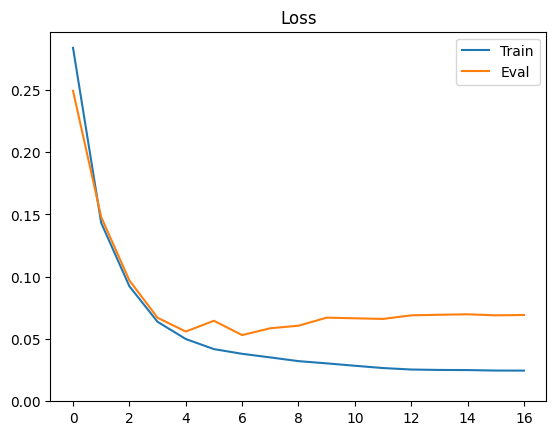

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 700ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 906ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 945ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 935ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 823ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 951ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 1s 1s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 4s 4s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['geometry'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step


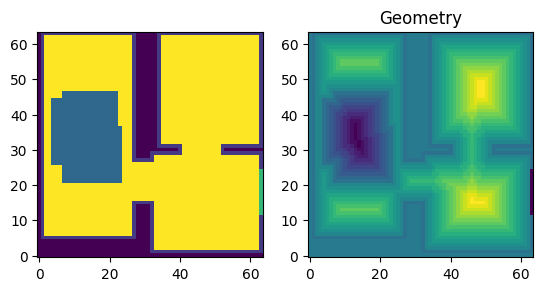

/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/usr/local/lib/python3.10/dist-packages/matplotlib/quiver.py:646: RuntimeWarn

In [ ]:
# bestes Modell trainieren und evaluieren
best_hps = tuner.get_best_hyperparameters(3)
best_hps

net = define_model_hp(best_hps[0], epoch_=20, return_net=True)
#net.model.summary()

net.build_model_(load=load, hp=True)

#history = model.fit(dataset.dataset_rho_v_train,
#                    epochs=20,
#                    validation_data=dataset.dataset_rho_v_val)